# **NLP COURSEWORK YELP REVIEWS**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 1) Loading the 'Yelp Reviews' Dataset from Hugging face

In [ ]:
import tensorflow as tf

# Check if TensorFlow can recognize the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU is detected. TensorFlow will run on CPU.")

1 Physical GPUs, 1 Logical GPUs


In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from datasets import Dataset
from datasets import load_dataset

In [ ]:
yelp_reviews = load_dataset('yelp_review_full')

#### 2) Exploratory Data Analysis (EDA)

In [ ]:
print(yelp_reviews)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})


The Yelp reviews full star dataset is constructed by randomly taking 130,000 training samples and 10,000 testing samples for each review star from 1 to 5. In total there are 650,000 trainig samples and 50,000 testing samples.

In [ ]:
# Access and print a few examples from the training set
yelp_reviews['train'][:5]

{'label': [4, 1, 3, 3, 0],
 'text': ["dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.",
  "Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You 

- Importing important Libraries

In [ ]:
from joblib import dump, load
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
# Convert the training dataset to a Pandas DataFrame
train_df = yelp_reviews['train'].to_pandas()

# Convert the test dataset to a Pandas DataFrame
test_df = yelp_reviews['test'].to_pandas()

# Define file paths where I want to save the dataset
train_path = '/content/drive/My Drive/Colab Notebooks/NLP/yelp_reviews_train.csv'
test_path = '/content/drive/My Drive/Colab Notebooks/NLP/yelp_reviews_test.csv'

# Save the DataFrames as CSV files in the Google Drive
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

In [ ]:
# Loading the dataset from drive
# Define the paths to the CSV files
train_path = '/content/drive/My Drive/Colab Notebooks/NLP/yelp_reviews_train.csv'
test_path = '/content/drive/My Drive/Colab Notebooks/NLP/yelp_reviews_test.csv'

# Load the training and test datasets from CSV files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [ ]:
train_df.head()

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


In [ ]:
test_df.head()

,label,text
0,0,I got 'new' tires from them and within two wee...
1,0,Don't waste your time. We had two different p...
2,0,All I can say is the worst! We were the only 2...
3,0,I have been to this restaurant twice and was d...
4,0,Food was NOT GOOD at all! My husband & I ate h...


In [ ]:
print(train_df.shape)
print(test_df.shape)

(650000, 2)
(50000, 2)


this dataset has altogether 700000 rows with 2 columns

- Examples of some of the text in each of the classes

In [ ]:
unique_classes = train_df['label'].unique()

examples = {}
for cls in unique_classes:
    # Select the first example of each class
    example = train_df[train_df['label'] == cls]['text'].iloc[0]
    examples[cls] = example

# Print examples
for cls, text in examples.items():
    print(f"Class {cls}: {text}\n")

Class 4: dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.

Class 1: Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you

In [ ]:
# printing out the examples of each class within a word limit to analyse in a better way
examples = {}
for cls in unique_classes:
    # Filter examples that have 30 words or fewer
    class_examples = train_df[train_df['label'] == cls]
    class_examples['word_count'] = class_examples['text'].apply(lambda x: len(x.split()))
    suitable_examples = class_examples[class_examples['word_count'] <= 30]

    # Select the first short example of each class, if available
    if not suitable_examples.empty:
        example = suitable_examples.iloc[0]['text']
        examples[cls] = example
    else:
        examples[cls] = "No example with 50 words or fewer."

# Print examples
for cls, text in examples.items():
    print(f"Class {cls}: {text}\n")

<ipython-input-10-56750225178e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_examples['word_count'] = class_examples['text'].apply(lambda x: len(x.split()))
<ipython-input-10-56750225178e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_examples['word_count'] = class_examples['text'].apply(lambda x: len(x.split()))
<ipython-input-10-56750225178e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

Class 4: Can't miss stop for the best Fish Sandwich in Pittsburgh.

Class 1: Hoofah.

Class 3: I heart King's. I've always been a fan and this one was as good as my old one in Monaca.

Class 0: Terrible service...terrible food...this place smells like rotten wet wood

Class 2: Its clean, open 24/7 with hot shoe string fries and creative milkshakes. What else do you want in life??



<ipython-input-10-56750225178e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_examples['word_count'] = class_examples['text'].apply(lambda x: len(x.split()))


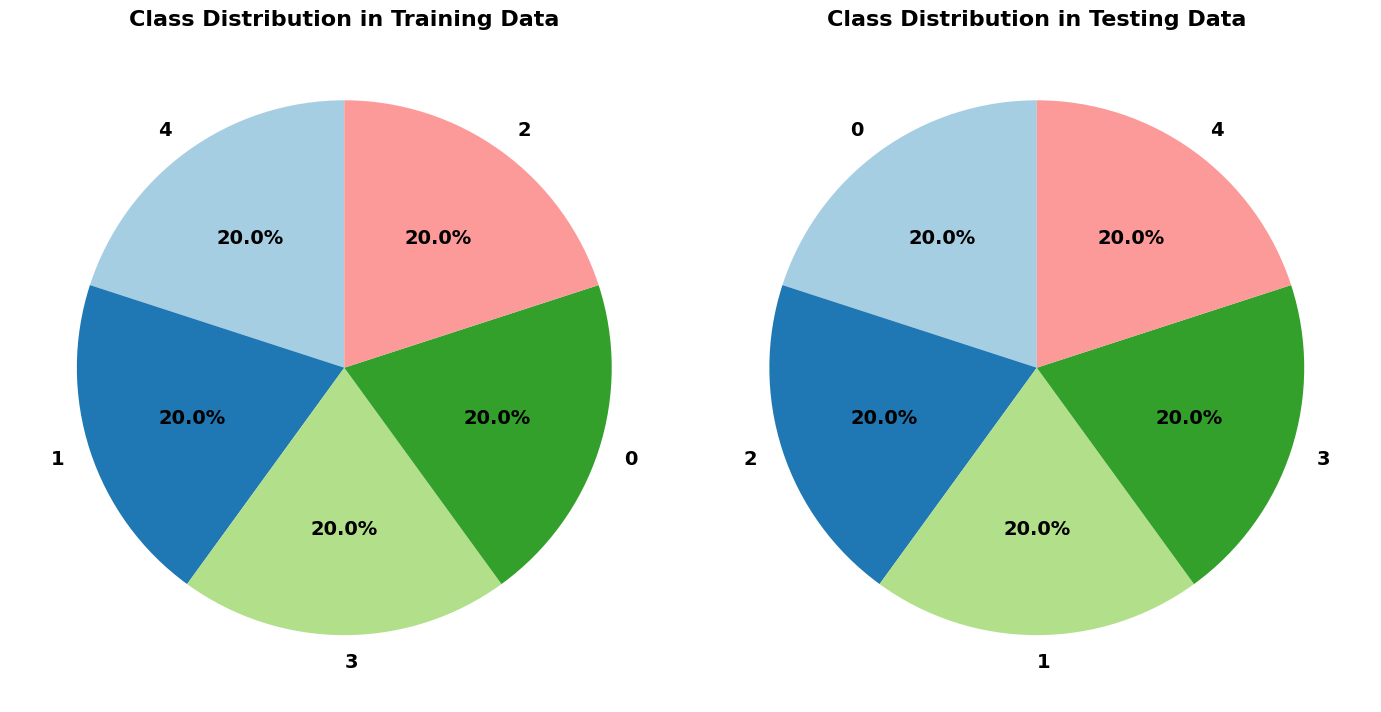

In [ ]:
# Seeing the distribution of the classes in both the provided sets

# Calculate class distributions
train_class_distribution = train_df['label'].value_counts()
test_class_distribution = test_df['label'].value_counts()

# Set up the figure for two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot for training data class distribution
ax[0].pie(train_class_distribution, labels=train_class_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(range(len(train_class_distribution))),
          textprops={'fontsize': 14, 'fontweight': 'bold'})
ax[0].set_title('Class Distribution in Training Data', fontsize=16, fontweight='bold')
ax[0].set_ylabel('')  # Suppress the y-label as it's clear it's about class distribution

# Plot for testing data class distribution
ax[1].pie(test_class_distribution, labels=test_class_distribution.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(range(len(test_class_distribution))),
          textprops={'fontsize': 14, 'fontweight': 'bold'})
ax[1].set_title('Class Distribution in Testing Data', fontsize=16, fontweight='bold')

# Show the plots
plt.tight_layout()
plt.show()

- Solitting the training set into training and validation set using 80:20 stratified split

In [ ]:
# Split the training data into further training and validation sets
train_df, val_df = train_test_split(
    train_df,  # Input the entire DataFrame
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=train_df['label']  # Stratify by the label column to maintain distribution
)

In [ ]:
# Retain DataFrame structure when referencing specific columns
train_texts = train_df[['text']]
train_labels = train_df[['label']]
val_texts = val_df[['text']]
val_labels = val_df[['label']]

# For the test set, since it's not being split
test_texts = test_df[['text']]
test_labels = test_df[['label']]

In [ ]:
# Checking the shape of the three sets' columns

print("Train texts shape:", train_texts.shape)
print("Train labels shape:", train_labels.shape)
print("Validation texts shape:", val_texts.shape)
print("Validation labels shape:", val_labels.shape)
print("Test texts shape:", test_texts.shape)
print("Test labels shape:", test_labels.shape)

Train texts shape: (520000, 1)
Train labels shape: (520000, 1)
Validation texts shape: (130000, 1)
Validation labels shape: (130000, 1)
Test texts shape: (50000, 1)
Test labels shape: (50000, 1)


#### 3) Preprocessing the text in yelp dataset in all three sets

In [ ]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # 1) Convert text to lowercase
    text = text.lower()

    # 2) Removing Noise
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\W+', ' ', text)  # Remove non-word characters
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # 3) Tokenize text
    tokens = word_tokenize(text)

    # 4) Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 5) Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Joining the tokens as it is ok for tf-idf vectorizor which is our first pipeline (baseline)
    return ' '.join(tokens)

# Apply the preprocessing function to each dataset
train_texts['text'] = train_texts['text'].apply(preprocess_text)
val_texts['text'] = val_texts['text'].apply(preprocess_text)
test_texts['text'] = test_texts['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-9-7d3481c4626e>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_texts['text'] = train_texts['text'].apply(preprocess_text)
<ipython-input-9-7d3481c4626e>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_te

In [ ]:
# Checking the text in training set after preprocessing
train_texts.head()

,text
428833,went taste lunch well get way first food good ...
122708,excellent service main reason giving star neve...
311033,found restaurant food network app got four tac...
36312,one pizza place get really excited visit lot i...
496430,frick chicken tucked strip mall right next fre...


In [ ]:
# Checking the text in validation set after preprocessing
val_texts.head()

,text
3455,place even stay business disgusting food crap ...
156214,bobby know todd pletcher talked buying smile k...
525557,came visit dad help annual house cleaning said...
254614,seems like people north scottsdale low standar...
127543,storybook castle gleam bring fanciful fable li...


In [ ]:
# Checking the text in test set after preprocessing
test_texts.head()

,text
0,got new tire within two week got flat took car...
1,waste time two different people come house giv...
2,say worst people place lunch place freezing lo...
3,restaurant twice disappointed time go back fir...
4,food good husband ate couple week ago first ti...


- Text Length analysis

In [ ]:
# Calculate word count for each text
train_texts['word_count'] = train_texts['text'].apply(lambda x: len(x.split()))
val_texts['word_count'] = val_texts['text'].apply(lambda x: len(x.split()))
test_texts['word_count'] = test_texts['text'].apply(lambda x: len(x.split()))

# Calculate character count for each text
train_texts['char_count'] = train_texts['text'].apply(len)
val_texts['char_count'] = val_texts['text'].apply(len)
test_texts['char_count'] = test_texts['text'].apply(len)

# Print descriptive statistics of word and character counts
print("Training Text - Word Counts:\n", train_texts['word_count'].describe())
print("Validation Text - Word Counts:\n", val_texts['word_count'].describe())
print("Test Text - Word Counts:\n", test_texts['word_count'].describe())

print("Training Text - Character Counts:\n", train_texts['char_count'].describe())
print("Validation Text - Character Counts:\n", val_texts['char_count'].describe())
print("Test Text - Character Counts:\n", test_texts['char_count'].describe())

Training Text - Word Counts:
 count    520000.000000
mean         67.572263
std          60.562663
min           0.000000
25%          27.000000
50%          50.000000
75%          88.000000
max         905.000000
Name: word_count, dtype: float64
Validation Text - Word Counts:
 count    130000.000000
mean         67.461031
std          60.418801
min           0.000000
25%          27.000000
50%          50.000000
75%          88.000000
max         712.000000
Name: word_count, dtype: float64
Test Text - Word Counts:
 count    50000.00000
mean        67.57310
std         60.46197
min          0.00000
25%         27.00000
50%         50.00000
75%         89.00000
max        587.00000
Name: word_count, dtype: float64
Training Text - Character Counts:
 count    520000.000000
mean        434.455037
std         392.205299
min           0.000000
25%         172.000000
50%         319.000000
75%         566.000000
max        4636.000000
Name: char_count, dtype: float64
Validation Text - Charact

from this text length analysis, we can see that most of the text's word counts are under 89 in all three sets, but also that there exists some varied texts whose word counts are bizzare (probably outliers). so we need to perform padding and truncation very carefully.

In [ ]:
# Count the number of zero-length texts based on word count
num_zero_word_train = (train_texts['word_count'] == 0).sum()
num_zero_word_val = (val_texts['word_count'] == 0).sum()
num_zero_word_test = (test_texts['word_count'] == 0).sum()

print("Number of zero-word texts in Training set:", num_zero_word_train)
print("Number of zero-word texts in Validation set:", num_zero_word_val)
print("Number of zero-word texts in Test set:", num_zero_word_test)

Number of zero-word texts in Training set: 44
Number of zero-word texts in Validation set: 9
Number of zero-word texts in Test set: 2


 Some machine learning models and vectorization techniques might throw errors or behave unpredictably when encountering zero-length texts during training or prediction. For instance, a text classifier using TF-IDF might generate an empty feature vector for such texts, leading to errors during model fitting or predictions.

In [ ]:
# Remove zero-word texts from the training set
train_texts = train_texts[train_texts['word_count'] > 0]
train_labels = train_labels.loc[train_texts.index]

# Remove zero-word texts from the validation set
val_texts = val_texts[val_texts['word_count'] > 0]
val_labels = val_labels.loc[val_texts.index]

# Remove zero-word texts from the test set
test_texts = test_texts[test_texts['word_count'] > 0]
test_labels = test_labels.loc[test_texts.index]

In [ ]:
# Verify removal
print("Remaining zero-word texts in Training set:", (train_texts['word_count'] == 0).sum())
print("Remaining zero-word texts in Validation set:", (val_texts['word_count'] == 0).sum())
print("Remaining zero-word texts in Test set:", (test_texts['word_count'] == 0).sum())

Remaining zero-word texts in Training set: 0
Remaining zero-word texts in Validation set: 0
Remaining zero-word texts in Test set: 0


- Saving the preprocessed datasets into the drive so as to not preprocess again and again

In [ ]:
# Save preprocessed training set
train_texts.to_csv('preprocessed_train_texts.csv', index=False)
train_labels.to_csv('preprocessed_train_labels.csv', index=False)

# Save preprocessed validation set
val_texts.to_csv('preprocessed_val_texts.csv', index=False)
val_labels.to_csv('preprocessed_val_labels.csv', index=False)

# Save preprocessed test set
test_texts.to_csv('preprocessed_test_texts.csv', index=False)
test_labels.to_csv('preprocessed_test_labels.csv', index=False)

In [ ]:
# Load preprocessed training set
preprocessed_train_texts = pd.read_csv('preprocessed_train_texts.csv')
preprocessed_train_labels = pd.read_csv('preprocessed_train_labels.csv')

# Load preprocessed validation set
preprocessed_val_texts = pd.read_csv('preprocessed_val_texts.csv')
preprocessed_val_labels = pd.read_csv('preprocessed_val_labels.csv')

# Load preprocessed test set
preprocessed_test_texts = pd.read_csv('preprocessed_test_texts.csv')
preprocessed_test_labels = pd.read_csv('preprocessed_test_labels.csv')

- Checking the distribution of classes in the training and validation sets

Training Set Class Distribution:
label
3    103997
2    103997
1    103994
4    103989
0    103979
Name: count, dtype: int64

Validation Set Class Distribution:
label
4    26000
3    25999
1    25998
2    25998
0    25996
Name: count, dtype: int64


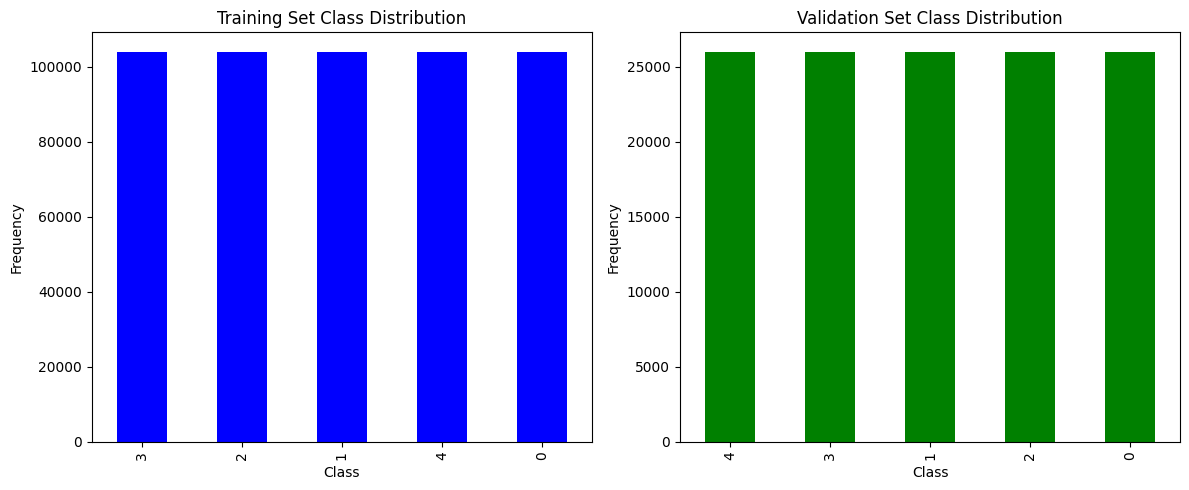

In [ ]:
# Checking the distribution of classes in the training set
train_class_distribution = preprocessed_train_labels['label'].value_counts()
print("Training Set Class Distribution:")
print(train_class_distribution)

# Checking the distribution of classes in the validation set
val_class_distribution = preprocessed_val_labels['label'].value_counts()
print("\nValidation Set Class Distribution:")
print(val_class_distribution)

# Plotting the distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_class_distribution.plot(kind='bar', color='blue', title='Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
val_class_distribution.plot(kind='bar', color='green', title='Validation Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

From this, it is clear that the stratify method for splitting the data worked as the distribution of all 5 classes are almost equal.

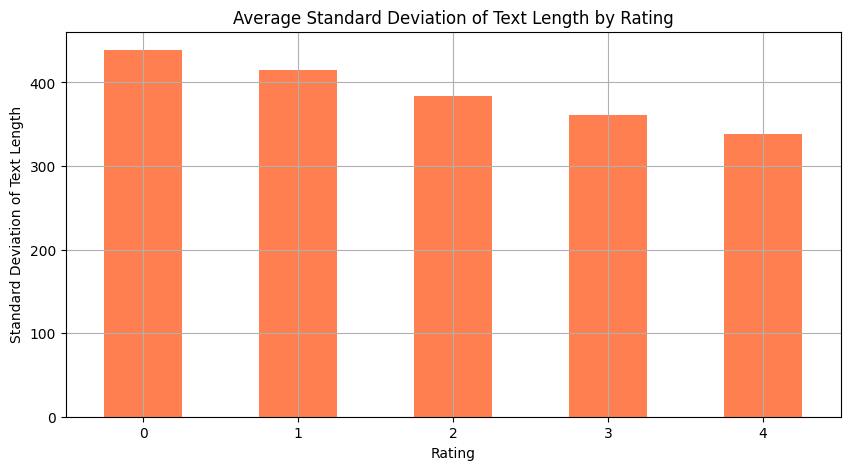

In [ ]:
# Combine texts and labels for easier manipulation
train_data = pd.concat([preprocessed_train_texts['text'], preprocessed_train_labels['label']], axis=1)
train_data.columns = ['text', 'rating']

# Calculate the length of each review
train_data['length'] = train_data['text'].apply(len)

# Group by rating and calculate the standard deviation of lengths
std_deviation_by_rating = train_data.groupby('rating')['length'].std()

# Plotting
plt.figure(figsize=(10, 5))
std_deviation_by_rating.plot(kind='bar', color='coral', title='Average Standard Deviation of Text Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Standard Deviation of Text Length')
plt.xticks()
plt.grid(True)
plt.show()

From this, we can see that the text length has very little to do with the classification task.

- Sentiment analysis to verify the ratings mean negative to positive sentiments like expected

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon
nltk.download('vader_lexicon')

# Combine texts and labels into a single DataFrame
train_data = pd.concat([preprocessed_train_texts, preprocessed_train_labels], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sia = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score
def get_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Apply the function to each review in training set
train_data['sentiment_score'] = train_data['text'].apply(get_sentiment_score)

In [ ]:
average_sentiment_per_rating = train_data.groupby('label')['sentiment_score'].mean()

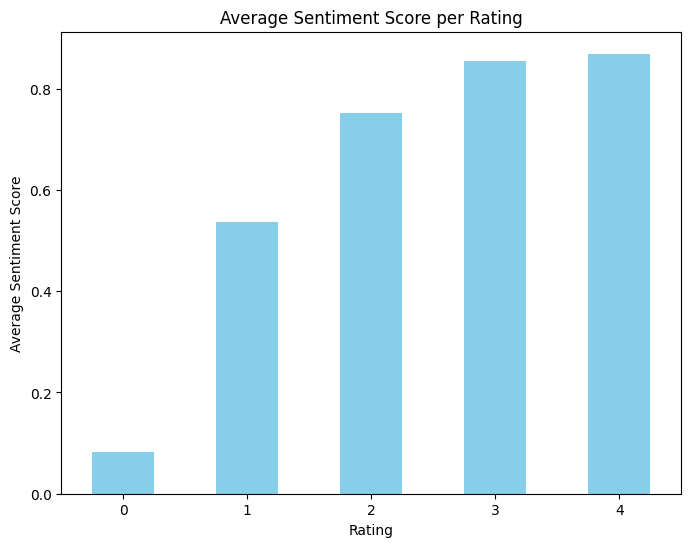

In [ ]:
plt.figure(figsize=(8, 6))
average_sentiment_per_rating.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment Score per Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()

 There is a clear positive correlation between the rating and the sentiment score, which suggests that as the numerical rating increases, the language used in the reviews expresses more positive sentiments.

- Understanding the length of the texts with respect to the ratings

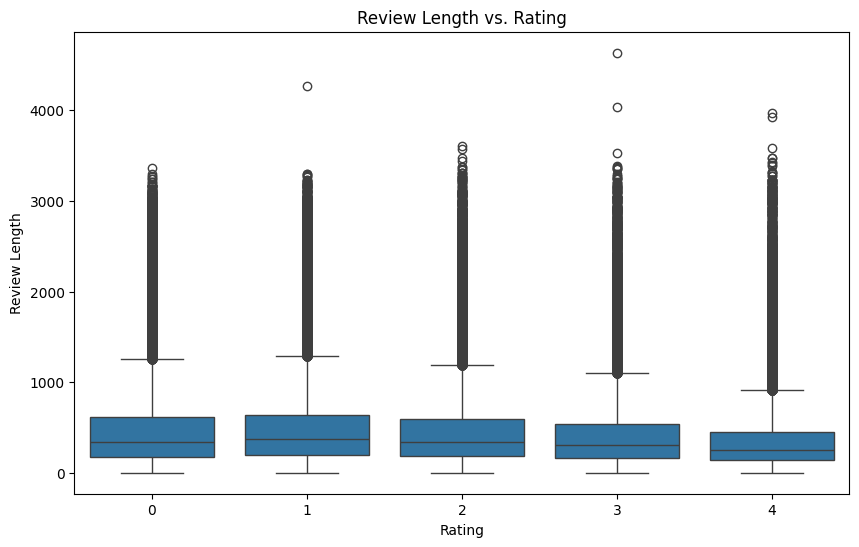

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'train_data' is already loaded and includes 'text' and 'rating' columns
train_data['review_length'] = train_data['text'].apply(len)

plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='review_length', data=train_data)
plt.title('Review Length vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.show()

This box plot provides a clear visual summary of how review lengths differ by ratings and highlights the need for careful consideration of these characteristics in data handling and modeling in NLP applications.

## Baseline : Naive Bayes with TF-IDF Vectorization
 **(Traditional Pipeline as Benchmark)**

- Getting TF-IDF vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training texts
X_train_tfidf = tfidf_vectorizer.fit_transform(preprocessed_train_texts['text'])

# Only transform the validation and test texts (do not fit to prevent data leakage)
X_val_tfidf = tfidf_vectorizer.transform(preprocessed_val_texts['text'])
X_test_tfidf = tfidf_vectorizer.transform(preprocessed_test_texts['text'])

- Get a baseline model for tf-idf and naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier on the training data and labels
nb_classifier.fit(X_train_tfidf, preprocessed_train_labels['label'])

MultinomialNB()

In [ ]:
# Getting a baseline model for TF-IDF and Naive bayes model

# Predict the labels for the validation set
val_predictions = nb_classifier.predict(X_val_tfidf)

# Print the classification report to evaluate the model
print("Validation Classification Report:\n", classification_report(preprocessed_val_labels['label'], val_predictions))
print("Validation Accuracy:", accuracy_score(val_labels['label'], val_predictions))

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.68      0.64     25996
           1       0.46      0.47      0.47     25998
           2       0.45      0.47      0.46     25998
           3       0.46      0.51      0.48     25999
           4       0.70      0.50      0.58     26000

    accuracy                           0.53    129991
   macro avg       0.54      0.53      0.53    129991
weighted avg       0.54      0.53      0.53    129991

Validation Accuracy: 0.5266518451277397


- Hyperparameter search for TF-IDF and Naive Bayes model

In [ ]:
# Create a pipeline with TF-IDF Vectorizer and Naive Bayes Classifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Define the parameter grid to search
param_grid = {
    'tfidf__max_df': [0.5, 0.75],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 1.0, 10.0]  # Smoothing parameter for Naive Bayes
}

# Initialize the GridSearchCV object with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, n_jobs=1, verbose=1, scoring='accuracy', cv=5)

# Fit GridSearchCV to the training data
grid_search.fit(preprocessed_train_texts['text'], preprocessed_train_labels['label'])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'nb__alpha': [0.1, 1.0, 10.0],
                         'tfidf__max_df': [0.5, 0.75], 'tfidf__min_df': [1, 2],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

- Evaluate the Best Model on validation set again

In [ ]:
# Print the best parameters found by the grid search
print("Best parameters:", grid_search.best_params_)

# Predict on the validation set using the best model
val_predictions = grid_search.predict(preprocessed_val_texts['text'])

# Output the classification report for the validation data
from sklearn.metrics import classification_report, accuracy_score
print("Validation Classification Report after hyperparameter tuning for TF-IDF NAIVEBAYES:\n", classification_report(preprocessed_val_labels['label'], val_predictions))
print("Validation Accuracy after hyperparameter tuning for TF-IDF NAIVEBAYES:", accuracy_score(preprocessed_val_labels['label'], val_predictions))

Best parameters: {'nb__alpha': 1.0, 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Validation Classification Report after hyperparameter tuning for TF-IDF NAIVEBAYES:
               precision    recall  f1-score   support

           0       0.65      0.69      0.67     25996
           1       0.49      0.54      0.51     25998
           2       0.50      0.52      0.51     25998
           3       0.49      0.55      0.52     25999
           4       0.75      0.51      0.61     26000

    accuracy                           0.56    129991
   macro avg       0.58      0.56      0.56    129991
weighted avg       0.58      0.56      0.56    129991

Validation Accuracy after hyperparameter tuning for TF-IDF NAIVEBAYES: 0.56168503973352


- saving the best model obtained after gridsearch

In [ ]:
from joblib import dump, load

# as grid_search is the GridSearchCV object
best_model_TFIDF_Naivebayes = grid_search.best_estimator_

# Define path in the Google Drive where we want to save the model
model_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_model_TFIDF_Naivebayes.joblib'

# Save the model
dump(best_model_TFIDF_Naivebayes, model_path)

['/content/drive/My Drive/Colab Notebooks/NLP/best_model_TFIDF_Naivebayes.joblib']

- Use the Best model for TFIDF + Naive Bayes to Test on test set

In [ ]:
# Using the best estimator directly from GridSearchCV
test_predictions = grid_search.best_estimator_.predict(preprocessed_test_texts['text'])
print("Test Classification Report:\n", classification_report(preprocessed_test_labels['label'], test_predictions))

Test Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66      9998
           1       0.48      0.53      0.51     10000
           2       0.49      0.52      0.50     10000
           3       0.49      0.54      0.51     10000
           4       0.75      0.51      0.61     10000

    accuracy                           0.56     49998
   macro avg       0.57      0.56      0.56     49998
weighted avg       0.57      0.56      0.56     49998



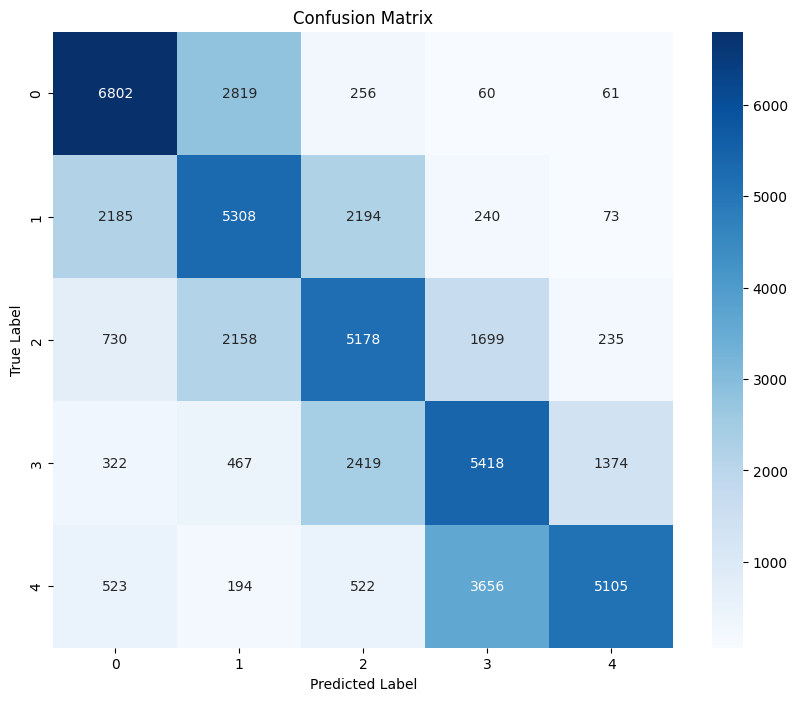


Test Classification Report on test set:
               precision    recall  f1-score   support

           0       0.64      0.68      0.66      9998
           1       0.48      0.53      0.51     10000
           2       0.49      0.52      0.50     10000
           3       0.49      0.54      0.51     10000
           4       0.75      0.51      0.61     10000

    accuracy                           0.56     49998
   macro avg       0.57      0.56      0.56     49998
weighted avg       0.57      0.56      0.56     49998

Test Accuracy for TF-IDF Naive Bayes: 0.5562422496899876


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from joblib import load

# Getting the loaded best model and then testing on test set
# Load the saved model
best_model_TFIDF_Naivebayes = load('/content/drive/My Drive/Colab Notebooks/NLP/best_model_TFIDF_Naivebayes.joblib')

# Predicting on test set
test_predictions = best_model_TFIDF_Naivebayes.predict(preprocessed_test_texts['text'])

# Compute confusion matrix
conf_matrix = confusion_matrix(preprocessed_test_labels['label'], test_predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nTest Classification Report on test set:\n", classification_report(preprocessed_test_labels['label'], test_predictions))

# Print accuracy score
print("Test Accuracy for TF-IDF Naive Bayes:", accuracy_score(preprocessed_test_labels['label'], test_predictions))

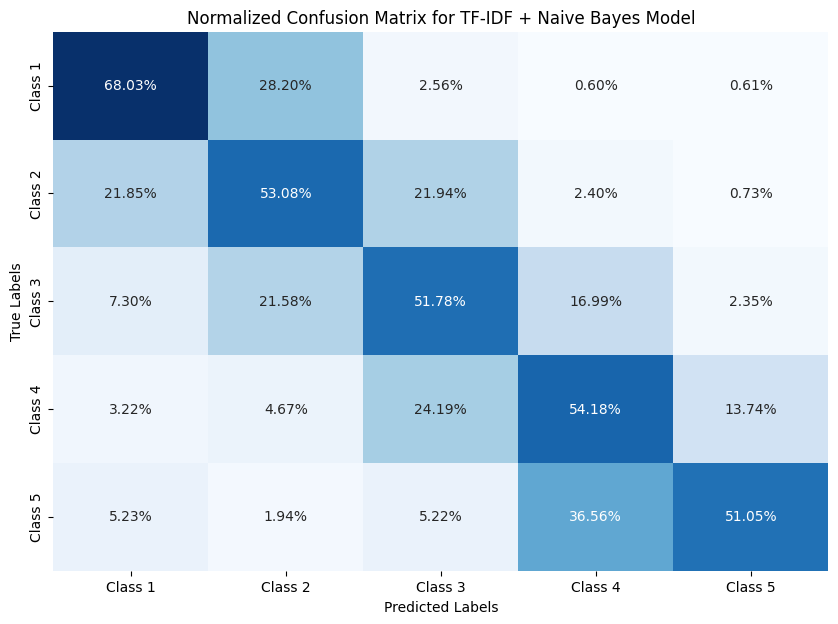

In [ ]:
# Making the normalized confusion Matrix from the above results

# Normalize the confusion matrix to show percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Format the annotations to display percentages only
annotations = [["{:.2f}%".format(value) for value in row] for row in conf_matrix_normalized]

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_normalized, annot=annotations, fmt="", cmap='Blues', cbar=False,
            xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'],
            yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.title('Normalized Confusion Matrix for TF-IDF + Naive Bayes Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

- Getting examples that were misclassified by TFIDF + Naive Bayes best Model

In [ ]:
# Load the saved TF-IDF + Naive Bayes model
best_model_TFIDF_Naivebayes = load('/content/drive/My Drive/Colab Notebooks/NLP/best_model_TFIDF_Naivebayes.joblib')

# Predicting on the test set
test_predictions = best_model_TFIDF_Naivebayes.predict(preprocessed_test_texts['text'])
true_labels = preprocessed_test_labels['label']

# Finding mismatches between true labels and predictions
mismatches = np.where(test_predictions != true_labels)[0]

# Create a list to store up to 10 examples of misclassification
misclassified_examples = []

# Iterate over the mismatches and store examples until we have 10
for idx in mismatches:
    if len(misclassified_examples) >= 10:
        break  # Stop collecting examples once we have 10
    true_class = true_labels.iloc[idx]  # Accessing the label using iloc for correct indexing
    predicted_class = test_predictions[idx]
    misclassified_examples.append({
        'Text': preprocessed_test_texts['text'].iloc[idx],  # Accessing the text using iloc for correct indexing
        'True Class': true_class,
        'Predicted Class': predicted_class
    })

# Print out the 10 misclassified examples using the tfidf + naive bayes model
for example in misclassified_examples:
    print(f"True Class: {example['True Class']}, Predicted Class: {example['Predicted Class']}")
    print(f"Text: {example['Text']}\n")

True Class: 0, Predicted Class: 1
Text: say worst people place lunch place freezing loaded kid toy bicycle scooter electronic keyboard graced dining room fish tank filthy slimy fingerprint smeared enjoyment nour food came water drink tea medium temperature food course cold like room never took jacket plate small food spill onto semi clean table sit completely worn booth seat fried noodle box nasty shrimp mushy fried rice bright yellow nwe asked water brought u solo cup people asked hot tea said minute chinese restaurant hot tea available upon request nover first last visit place good point cheap deservingly

True Class: 0, Predicted Class: 1
Text: food good husband ate couple week ago first time ordered salad basil pesto cream pasta husband ordered spinach feta pasta salad huge plate spring mix nothing else way much vinegar dressing lettuce drowning vinegar pesto pasta flavor taste like cream sauce pesto runny watery way much sauce enough noodle husband pasta even le flavor mine ate qu

## LSTM with FastText Embeddings
**(Neural Network use)**

In [ ]:
print(preprocessed_train_texts.shape)
print(preprocessed_train_labels.shape)
print(preprocessed_val_texts.shape)
print(preprocessed_val_labels.shape)
print(preprocessed_test_texts.shape)
print(preprocessed_test_labels.shape)

(519956, 3)
(519956, 1)
(129991, 3)
(129991, 1)
(49998, 3)
(49998, 1)


- First tried Word2VEc for vectorizer

- Tokenize the preprocessed texts as they were joined above for tf-idf but need it tokenized for pretrained vectorizors like Word2Vec

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
# Tokenize the text in preprocessed datasets
tokenized_train_texts = preprocessed_train_texts['text'].apply(word_tokenize)
tokenized_val_texts = preprocessed_val_texts['text'].apply(word_tokenize)
tokenized_test_texts = preprocessed_test_texts['text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


- Vectorizing the tokenized preprocessed texts using pretrained Word2Vec vectorizer

In [ ]:
from gensim.models import KeyedVectors

# Load the pre-trained Word2Vec model which was downloaded from : 'https://github.com/harmanpreet93/load-word2vec-google'
# These pre-trained vectors are trained on part of Google News dataset on about 100 billion words.
# The model contains 300-dimensional vectors for about 3 million words and phrases.
word2vec_model_path = '/content/drive/My Drive/Colab Notebooks/NLP/GoogleNews-vectors-negative300.bin'
word_vectors = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

# Function to vectorize a sentence
def vectorize_sentence(sentence, word_vectors, embedding_dim):
    # Initialize an empty array for the sentence vector
    sentence_vector = np.zeros((len(sentence), embedding_dim))

    # For each word in the sentence, get its Word2Vec embedding (if available)
    for i, word in enumerate(sentence):
        if word in word_vectors:
            sentence_vector[i] = word_vectors[word]

    # Take the average of all word vectors to get the sentence vector
    if len(sentence) > 0:
        return np.mean(sentence_vector, axis=0)
    else:
        return np.zeros(embedding_dim)  # Return zeros if no word vectors were found

# Apply vectorization to tokenized datasets
embedding_dim = 300 # specifying the dimensions that is already 300 as this is a pretrained model
train_embeddings = tokenized_train_texts.apply(lambda x: vectorize_sentence(x, word_vectors, embedding_dim))
val_embeddings = tokenized_val_texts.apply(lambda x: vectorize_sentence(x, word_vectors, embedding_dim))
test_embeddings = tokenized_test_texts.apply(lambda x: vectorize_sentence(x, word_vectors, embedding_dim))

In [ ]:
train_embeddings

0         [0.006768798828125, 0.03745783025568182, -0.01...
1         [0.04455413818359375, 0.0482269287109375, -0.0...
2         [-0.03978271484375, -0.0355255126953125, -0.01...
3         [-0.014023079359826962, 0.02915235787383781, 0...
4         [0.013932727632068452, 0.043815673343719, 0.03...
                                ...                        
519951    [-0.0135198974609375, 0.018973922729492186, 0....
519952    [0.019437760047997937, 0.03180559742904083, -0...
519953    [0.015769264914772728, 0.08070512251420454, 0....
519954    [0.019182477678571428, 0.0908203125, 0.0100054...
519955    [-0.012607655626662235, 0.022102031301944814, ...
Name: text, Length: 519956, dtype: object

In [ ]:
# Check the shape of embeddings
print("Shape of train tokens:",tokenized_train_texts.shape)
print("Shape of train embeddings:", train_embeddings.shape)
print("Shape of validation tokens:",tokenized_val_texts.shape)
print("Shape of validation embeddings:", val_embeddings.shape)
print("Shape of test tokens:",tokenized_test_texts.shape)
print("Shape of test embeddings:", test_embeddings.shape)

Shape of train tokens: (519956,)
Shape of train embeddings: (519956,)
Shape of validation tokens: (129991,)
Shape of validation embeddings: (129991,)
Shape of test tokens: (49998,)
Shape of test embeddings: (49998,)


In [ ]:
# calculating how many words are being recognized by this pretrained Word2Vec vectorization model
all_words = set(word for text in tokenized_train_texts for word in text)
known_words = {word for word in all_words if word in word_vectors}
unknown_words = all_words - known_words

print(f"Train set - Known words: {len(known_words)}")
print(f"Train set - Unknown words: {len(unknown_words)}")
print(f"Train set - Coverage: {len(known_words) / len(all_words) * 100:.2f}%")


# For the validation set
all_words_val = set(word for text in tokenized_val_texts for word in text)
known_words_val = {word for word in all_words_val if word in word_vectors}
unknown_words_val = all_words_val - known_words_val

print(f"Validation Set - Known words: {len(known_words_val)}")
print(f"Validation Set - Unknown words: {len(unknown_words_val)}")
print(f"Validation Set - Coverage: {len(known_words_val) / len(all_words_val) * 100:.2f}%")

# For the test set
all_words_test = set(word for text in tokenized_test_texts for word in text)
known_words_test = {word for word in all_words_test if word in word_vectors}
unknown_words_test = all_words_test - known_words_test

print(f"Test Set - Known words: {len(known_words_test)}")
print(f"Test Set - Unknown words: {len(unknown_words_test)}")
print(f"Test Set - Coverage: {len(known_words_test) / len(all_words_test) * 100:.2f}%")

Train set - Known words: 63679
Train set - Unknown words: 126701
Train set - Coverage: 33.45%
Validation Set - Known words: 46977
Validation Set - Unknown words: 49333
Validation Set - Coverage: 48.78%
Test Set - Known words: 36175
Test Set - Unknown words: 24123
Test Set - Coverage: 59.99%


This discrepancy suggests that this pre-trained model does not adequately represent the vocabulary specific to this dataset, especially for the training set where only 33% of the vocabulary is recognized

- Using Fasttext to train the model for vectorization on our dataset instead of using word2vec

In [ ]:
from gensim.models import FastText

# Train a FastText model on our tokenized training set
fasttext_model = FastText(sentences=tokenized_train_texts, vector_size=100, window=5, min_count=1, workers=4, sg=1)

In [ ]:
# tokenized_train_texts is a list of lists of tokens from the training dataset
all_words_train = set(word for text in tokenized_train_texts for word in text)
directly_known_words_train = {word for word in all_words_train if word in fasttext_model.wv.key_to_index}
directly_unknown_words_train = all_words_train - directly_known_words_train

print(f"Train set - Directly Known words: {len(directly_known_words_train)}")
print(f"Train set - Directly Unknown words (covered by subwords): {len(directly_unknown_words_train)}")
print(f"Train set - Direct Coverage: {len(directly_known_words_train) / len(all_words_train) * 100:.2f}%")

# Validation set
all_words_val = set(word for text in tokenized_val_texts for word in text)
directly_known_words_val = {word for word in all_words_val if word in fasttext_model.wv.key_to_index}
directly_unknown_words_val = all_words_val - directly_known_words_val

print(f"Validation Set - Directly Known words: {len(directly_known_words_val)}")
print(f"Validation Set - Directly Unknown words (covered by subwords): {len(directly_unknown_words_val)}")
print(f"Validation Set - Direct Coverage: {len(directly_known_words_val) / len(all_words_val) * 100:.2f}%")

# Test set
all_words_test = set(word for text in tokenized_test_texts for word in text)
directly_known_words_test = {word for word in all_words_test if word in fasttext_model.wv.key_to_index}
directly_unknown_words_test = all_words_test - directly_known_words_test

print(f"Test Set - Directly Known words: {len(directly_known_words_test)}")
print(f"Test Set - Directly Unknown words (covered by subwords): {len(directly_unknown_words_test)}")
print(f"Test Set - Direct Coverage: {len(directly_known_words_test) / len(all_words_test) * 100:.2f}%")

Train set - Directly Known words: 190380
Train set - Directly Unknown words (covered by subwords): 0
Train set - Direct Coverage: 100.00%
Validation Set - Directly Known words: 73107
Validation Set - Directly Unknown words (covered by subwords): 23203
Validation Set - Direct Coverage: 75.91%
Test Set - Directly Known words: 51309
Test Set - Directly Unknown words (covered by subwords): 8989
Test Set - Direct Coverage: 85.09%


From this, it is clear that training fasttext model was more beneficial for our dataset as it recognized most of the words in our text and thus will give better results on the ML algorithms for classification.

- Saving the fasttext model so as to not train it again and again

In [ ]:
# Save the model
fasttext_model.save('/content/drive/My Drive/Colab Notebooks/NLP/fasttext_model.bin')

- loading the model from drive

In [ ]:
# Load the model
from gensim.models import FastText
fasttext_model = FastText.load('/content/drive/My Drive/Colab Notebooks/NLP/fasttext_model.bin')

- Quality check of the trained FastText model

In [ ]:
# vector representation of the word "good" as produced by the trained FastText model.
print(fasttext_model.wv['good'])

[-0.08091895  0.15584025 -0.31960008  0.14040019 -0.06438775 -0.12775154
  0.12189353  0.26710245  0.23444158 -0.16122887  0.01142221  0.19503023
 -0.21419138  0.24795008  0.22708645 -0.18685213 -0.06879527 -0.09109796
 -0.05805187 -0.18154465  0.0152338   0.03076133  0.02999776  0.11182898
 -0.2814802  -0.16605122  0.06024628  0.41691887  0.5731316  -0.0298928
 -0.5039826   0.16065641  0.27127612  0.06409175 -0.08672607  0.4780214
  0.01728915  0.36525849 -0.0459183  -0.0066004   0.17754486 -0.01086345
  0.50394493  0.13459729 -0.15916027 -0.02485978 -0.6208145  -0.35055754
  0.27621883  0.13299547  0.00649825 -0.08116618  0.33881196  0.29389945
  0.17121655  0.1154376   0.07768253  0.06302437  0.11261541 -0.45233288
  0.07979059 -0.17277302 -0.18979946  0.5229414   0.20997171  0.35891226
 -0.09107013 -0.05883904  0.17219818  0.33264998  0.05443073  0.0231514
  0.34563592 -0.05579585  0.27314237  0.06543063  0.28327724  0.06214711
 -0.15522133  0.18343331 -0.18460225  0.03974495 -0.12

In [ ]:
# Looking at the most similar words of the input word according to Fasttext trained model
fasttext_model.wv.most_similar('best')

[('greatest', 0.8415078520774841),
 ('favoritest', 0.8360127806663513),
 ('okayest', 0.8130763173103333),
 ('mbest', 0.8121106624603271),
 ('thebest', 0.8054565787315369),
 ('laest', 0.8037070035934448),
 ('tastiest', 0.8035028576850891),
 ('juciest', 0.8015722036361694),
 ('nbest', 0.801243245601654),
 ('wisest', 0.7972831130027771)]

In [ ]:
# Check similarity between words
similarity = fasttext_model.wv.similarity('love', 'hate')
print("Similarity between 'word1' and 'word2':", similarity)

Similarity between 'word1' and 'word2': 0.7123768


 FastText's ability to handle any word through its subword mechanics makes it highly suitable for datasets with a diverse vocabulary and ensures that less words are left without embedding.While our quality checks did reveal that some words with opposite meanings showed unexpectedly high similarities, these instances were limited. Overall, FastText demonstrated strong performance in accurately grouping semantically similar words. Hence using FastText as a vectorization tool instead of Word2vec.

The Neural network and Transformer pipeline will need same legth of texts as inputs so let us visualize how the lengths differ for out datasets

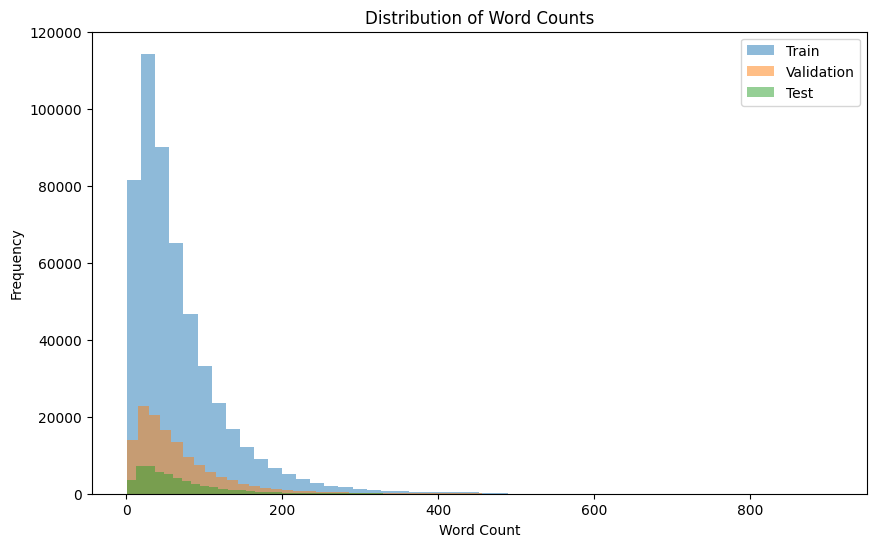

In [ ]:
# Plot histograms of word counts
plt.figure(figsize=(10, 6))
plt.hist(preprocessed_train_texts['word_count'], bins=50, alpha=0.5, label='Train')
plt.hist(preprocessed_val_texts['word_count'], bins=50, alpha=0.5, label='Validation')
plt.hist(preprocessed_test_texts['word_count'], bins=50, alpha=0.5, label='Test')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

- All three datasets (Train, Validation, Test) predominantly exhibit a right-skewed distribution. This suggests that most texts have a lower word count, with fewer texts reaching higher word counts.
- The majority of texts have word counts clustered towards the lower end of the scale, with frequencies decreasing sharply as word count increases.
- There are a significant number of texts (especially in the training set) with very low word counts, near zero.
- The training, validation, and test datasets appear to have similar distributions in terms of word count. This is good for model training as it ensures that the training, validation, and test sets are representative of the same population.

In [ ]:
# Text Length Analysis after preprocessing

# Calculate word count for each text
preprocessed_train_texts['word_count'] = preprocessed_train_texts['text'].apply(lambda x: len(x.split()))
preprocessed_val_texts['word_count'] = preprocessed_val_texts['text'].apply(lambda x: len(x.split()))
preprocessed_test_texts['word_count'] = preprocessed_test_texts['text'].apply(lambda x: len(x.split()))

# Print descriptive statistics of word and character counts
print("Preprocessed Training Text - Word Counts:\n", preprocessed_train_texts['word_count'].describe())
print("Preprocessed Validation Text - Word Counts:\n", preprocessed_val_texts['word_count'].describe())
print("Preprocessed Test Text - Word Counts:\n", preprocessed_test_texts['word_count'].describe())

Preprocessed Training Text - Word Counts:
 count    519956.000000
mean         67.577982
std          60.562035
min           1.000000
25%          27.000000
50%          50.000000
75%          88.000000
max         905.000000
Name: word_count, dtype: float64
Preprocessed Validation Text - Word Counts:
 count    129991.000000
mean         67.465701
std          60.418285
min           1.000000
25%          27.000000
50%          50.000000
75%          88.000000
max         712.000000
Name: word_count, dtype: float64
Preprocessed Test Text - Word Counts:
 count    49998.000000
mean        67.575803
std         60.461669
min          1.000000
25%         27.000000
50%         50.000000
75%         89.000000
max        587.000000
Name: word_count, dtype: float64


The diversity in our datasets is evident from the significant difference between the minimum and maximum sequence lengths, as well as the relatively high standard deviation, indicating variability in text lengths. Choosing the maximum length for padding and truncation is critical, balancing computational efficiency and information retention. Given that the 75th percentile for all three datasets is close to 88, opting for a maximum sequence length of 100 seems reasonable. This decision ensures inclusivity while managing computational demands.

**Vectorization Using trained FastText and padding and truncation for standardizing the length of the texts for neural network**

In [ ]:
from keras.preprocessing.sequence import pad_sequences

def vectorize_sequences(texts, model, max_length):
    # Initialize a list to store the sequence of vectors
    sequences = []
    for sentence in texts:
        # Initialize an empty list for storing word vectors
        sentence_seq = []
        for word in sentence:
            if word in model.wv:  # Check if the word is in the FastText model
                sentence_seq.append(model.wv[word])
            else:
                # Append a zero vector for words not in the model
                sentence_seq.append(np.zeros(model.vector_size))
        sequences.append(sentence_seq)
    # Pad sequences to ensure consistent input size
    return pad_sequences(sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post', value=0.0)

# Define maximum sequence length
max_seq_length = 100

# Apply vectorization to dataset
train_sequences = vectorize_sequences(tokenized_train_texts, fasttext_model, max_seq_length)
val_sequences = vectorize_sequences(tokenized_val_texts, fasttext_model, max_seq_length)
test_sequences = vectorize_sequences(tokenized_test_texts, fasttext_model, max_seq_length)

In [ ]:
# Check the shape of padded sequences
print("Shape of padded train embeddings:", train_sequences.shape)
print("Shape of padded validation embeddings:", val_sequences.shape)
print("Shape of padded test embeddings:", test_sequences.shape)

Shape of padded train embeddings: (519956, 100, 100)
Shape of padded validation embeddings: (129991, 100, 100)
Shape of padded test embeddings: (49998, 100, 100)


- One-hot Encoding the labels as this is needed for LSTM

In [ ]:
from keras.utils import to_categorical

# As we have numeric labels from 0 to 4 for the 5 classes
train_labels_encoded = to_categorical(preprocessed_train_labels, num_classes=5)
val_labels_encoded = to_categorical(preprocessed_val_labels, num_classes=5)
test_labels_encoded = to_categorical(preprocessed_test_labels, num_classes=5)

- Iteration 1 (trying different parameters and architecture for my dataset for LSTM model)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model architecture
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(100, 100)))
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(LSTM(64))  # Another LSTM layer, without return_sequences to flatten the output
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))  # softmax as it is a multiclass problem

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           42240     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 75589 (295.27 KB)
Trainable params: 75589 (295.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fit the model on the training data
history1 = model.fit(train_sequences, train_labels_encoded, epochs=20, batch_size=64,
                    validation_data=(val_sequences, val_labels_encoded))

Epoch 1/20
8125/8125 [==============================] - 121s 14ms/step - loss: 1.0805 - accuracy: 0.5269 - val_loss: 0.9762 - val_accuracy: 0.5713
Epoch 2/20
8125/8125 [==============================] - 109s 13ms/step - loss: 0.9783 - accuracy: 0.5729 - val_loss: 0.9497 - val_accuracy: 0.5838
Epoch 3/20
8125/8125 [==============================] - 108s 13ms/step - loss: 0.9558 - accuracy: 0.5833 - val_loss: 0.9282 - val_accuracy: 0.5920
Epoch 4/20
8125/8125 [==============================] - 109s 13ms/step - loss: 0.9411 - accuracy: 0.5898 - val_loss: 0.9329 - val_accuracy: 0.5902
Epoch 5/20
8125/8125 [==============================] - 108s 13ms/step - loss: 0.9199 - accuracy: 0.5979 - val_loss: 0.9123 - val_accuracy: 0.5988
Epoch 6/20
8125/8125 [==============================] - 108s 13ms/step - loss: 0.9062 - accuracy: 0.6043 - val_loss: 0.8986 - val_accuracy: 0.6052
Epoch 7/20
8125/8125 [==============================] - 108s 13ms/step - loss: 0.8946 - accuracy: 0.6091 - val_loss: 0

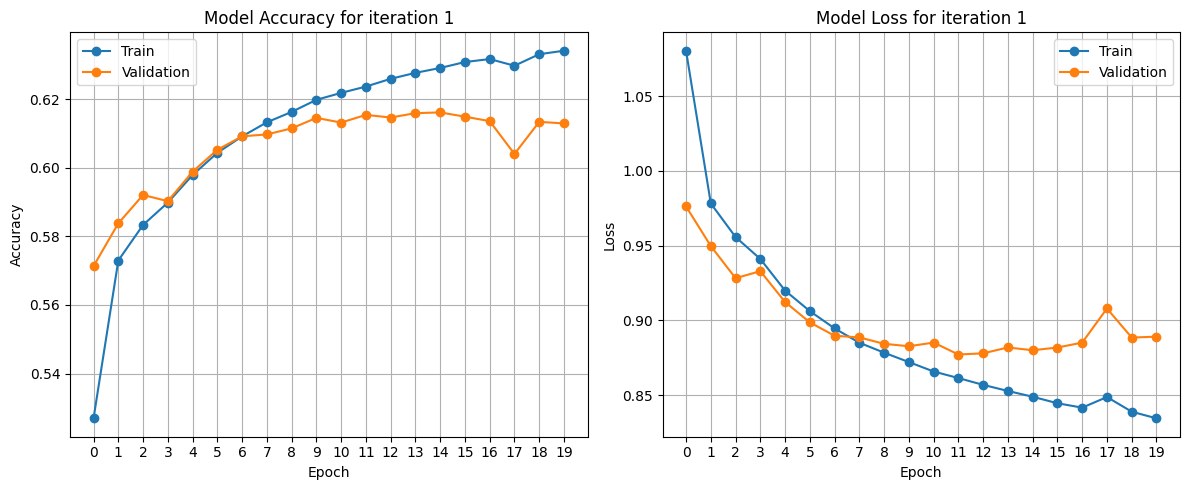

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Train', marker='o')
plt.plot(history1.history['val_accuracy'], label='Validation', marker='o')
plt.title('Model Accuracy for iteration 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, len(history1.history['accuracy'])))
plt.grid(True)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Train', marker='o')
plt.plot(history1.history['val_loss'], label='Validation', marker='o')
plt.title('Model Loss for iteration 1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, len(history1.history['loss'])))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

The training and validation curves of our LSTM model indicate that it is learning consistently, with a peak validation accuracy of approximately 61.8%. The parallel trends between the training and validation accuracy and loss suggest that the model is generalizing well without overfitting. However, the modest accuracy and relatively high loss indicate that the model might be too simple to capture the complex patterns in the data. To address this, increasing the complexity of the LSTM model could be beneficial, potentially improving both performance metrics. hence going for iteration 2.

- Iteration 2 (using different combinations to try to get better results from the past model)
1. increasing the complexity by increasing the hidden neurons to 128 in both the layers.
2. increasing the dropout rate.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Configure the learning rate
optimizer = Adam(learning_rate=0.001)

# Define the model architecture with updated parameters
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(100, 100)))  # Increased units
model.add(Dropout(0.4))  # Increased dropout rate
model.add(LSTM(128))  # Matching number of units in the second LSTM layer
model.add(Dropout(0.4))  # Consistent dropout rate
model.add(Dense(5, activation='softmax'))  # Assuming a 5-class problem

# Compile the model with the custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 249477 (974.52 KB)
Trainable params: 249477 (974.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model with early stopping
history2 = model.fit(train_sequences, train_labels_encoded, epochs=50, batch_size=64,
                    validation_data=(val_sequences, val_labels_encoded), callbacks=[early_stopping])

Epoch 1/50
8125/8125 [==============================] - 130s 15ms/step - loss: 1.0765 - accuracy: 0.5278 - val_loss: 1.0004 - val_accuracy: 0.5627
Epoch 2/50
8125/8125 [==============================] - 113s 14ms/step - loss: 0.9698 - accuracy: 0.5767 - val_loss: 0.9442 - val_accuracy: 0.5835
Epoch 3/50
8125/8125 [==============================] - 112s 14ms/step - loss: 0.9455 - accuracy: 0.5876 - val_loss: 0.9179 - val_accuracy: 0.5971
Epoch 4/50
8125/8125 [==============================] - 112s 14ms/step - loss: 0.9138 - accuracy: 0.6016 - val_loss: 0.8982 - val_accuracy: 0.6094
Epoch 5/50
8125/8125 [==============================] - 112s 14ms/step - loss: 0.8923 - accuracy: 0.6110 - val_loss: 0.8908 - val_accuracy: 0.6107
Epoch 6/50
8125/8125 [==============================] - 112s 14ms/step - loss: 0.8757 - accuracy: 0.6182 - val_loss: 0.8774 - val_accuracy: 0.6157
Epoch 7/50
8125/8125 [==============================] - 112s 14ms/step - loss: 0.8621 - accuracy: 0.6236 - val_loss: 0

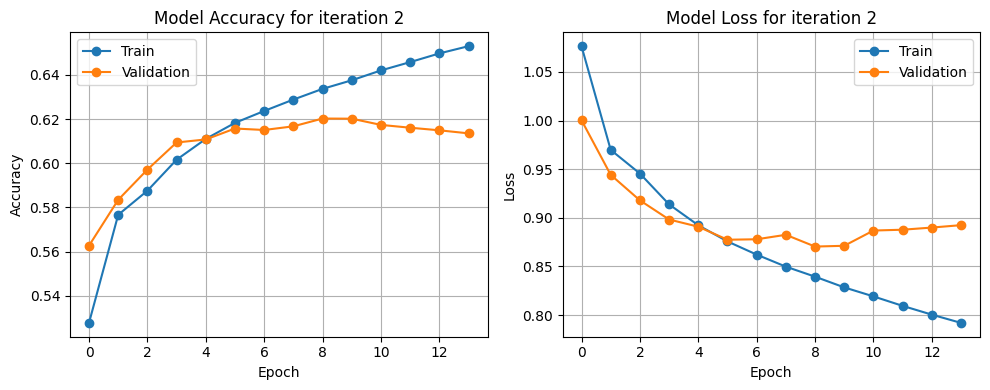

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], marker='o', label='Train')
plt.plot(history2.history['val_accuracy'], marker='o', label='Validation')
plt.title('Model Accuracy for iteration 2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], marker='o', label='Train')
plt.plot(history2.history['val_loss'], marker='o', label='Validation')
plt.title('Model Loss for iteration 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

 In response to the initial model's limitations, the second iteration involved enhancing the model's complexity. We doubled the number of units in both LSTM layers to 128 and increased the dropout rate to 0.4 to prevent overfitting. This version of the model also incorporated an early stopping mechanism to halt training if the validation loss ceased to decrease, thereby optimizing performance and computational efficiency. Training this enhanced model over 50 epochs resulted in improved accuracy, indicating better handling of complex patterns in the data.

- Iteration 3 (increasing the complexity and the number of layers along wiht dropout to deal with overfitting)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
# Configure the learning rate
optimizer = Adam(learning_rate=0.0005)  # Adjusted learning rate

# Define the model architecture with updated parameters
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(100, 100)))  # Increased units and complexity
model.add(Dropout(0.5))  # Increased dropout rate
model.add(LSTM(128, return_sequences=True))  # Added another LSTM layer
model.add(Dropout(0.5))  # Consistent dropout rate
model.add(LSTM(128))  # Added another LSTM layer
model.add(Dropout(0.5))  # Consistent dropout rate
model.add(Dense(64, activation='relu'))  # Added a dense layer for more non-linearity
model.add(Dropout(0.5))  # Consistent dropout rate
model.add(Dense(5, activation='softmax'))  # for 5-class problem

# Compile the model with the custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          365568    
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          197120    
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [ ]:
# Train the model with early stopping
history3 = model.fit(train_sequences, train_labels_encoded, epochs=50, batch_size=64,
                     validation_data=(val_sequences, val_labels_encoded), callbacks=[early_stopping])

Epoch 1/50
5200/5200 [==============================] - 117s 21ms/step - loss: 1.1168 - accuracy: 0.5143 - val_loss: 0.9956 - val_accuracy: 0.5558
Epoch 2/50
5200/5200 [==============================] - 102s 20ms/step - loss: 1.0100 - accuracy: 0.5645 - val_loss: 0.9513 - val_accuracy: 0.5806
Epoch 3/50
5200/5200 [==============================] - 100s 19ms/step - loss: 0.9743 - accuracy: 0.5785 - val_loss: 0.9315 - val_accuracy: 0.5904
Epoch 4/50
5200/5200 [==============================] - 98s 19ms/step - loss: 0.9500 - accuracy: 0.5899 - val_loss: 0.9457 - val_accuracy: 0.5859
Epoch 5/50
5200/5200 [==============================] - 98s 19ms/step - loss: 0.9295 - accuracy: 0.5992 - val_loss: 0.9017 - val_accuracy: 0.6064
Epoch 6/50
5200/5200 [==============================] - 98s 19ms/step - loss: 0.9131 - accuracy: 0.6055 - val_loss: 0.8923 - val_accuracy: 0.6088
Epoch 7/50
5200/5200 [==============================] - 98s 19ms/step - loss: 0.8980 - accuracy: 0.6109 - val_loss: 0.887

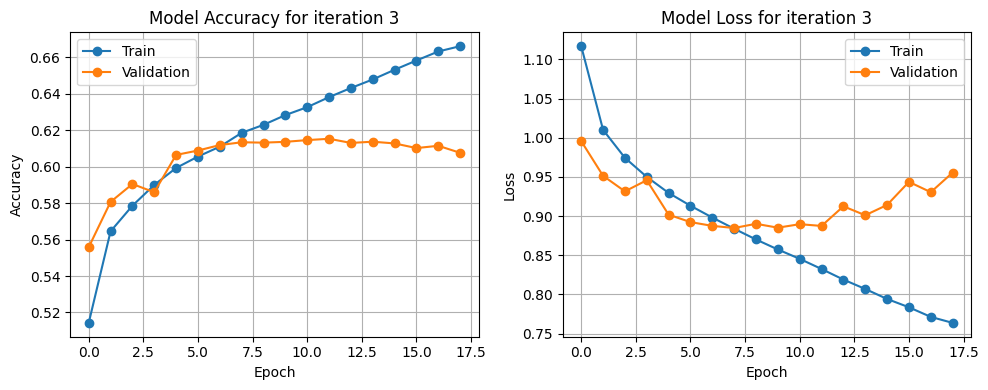

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], marker='o', label='Train')
plt.plot(history3.history['val_accuracy'], marker='o', label='Validation')
plt.title('Model Accuracy for iteration 3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], marker='o', label='Train')
plt.plot(history3.history['val_loss'], marker='o', label='Validation')
plt.title('Model Loss for iteration 3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Despite improvements, further tuning was needed to address lingering overfitting issues and to strive for even higher accuracy. Thus, the third iteration further increased the model complexity and added additional LSTM and dropout layers. The learning rate was reduced to refine weight adjustments during training, and the dropout rate was raised to 0.5 to robustly combat overfitting. This setup was also subject to early stopping based on validation loss.
The best results were obtained with the second iteration, where the balance between model complexity and performance optimization was most effective according to our validation accuracy assessments.

- Saving the best model from iteration 2 as we saw the highest accuracy on validation set there

In [ ]:
# Identify the epoch with the highest validation accuracy
best_epoch = np.argmax(history2.history['val_accuracy']) + 1  # Adding 1 because epochs are 1-indexed

# Save the model at the best epoch
best_model_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_model_lstm.h5'
model.save(best_model_path.format(best_epoch))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- Testing the best model for LSTM saved on test set

1563/1563 [==============================] - 12s 7ms/step
Classification Report for best LSTM model:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      9998
           1       0.55      0.54      0.54     10000
           2       0.55      0.48      0.51     10000
           3       0.51      0.58      0.55     10000
           4       0.73      0.65      0.69     10000

    accuracy                           0.61     49998
   macro avg       0.61      0.61      0.61     49998
weighted avg       0.61      0.61      0.61     49998



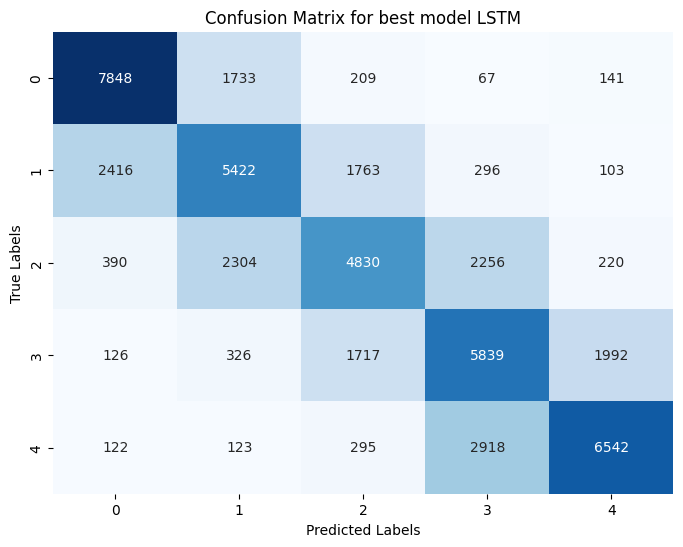

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Loading the best model saved from lstm from the drive
best_model_lstm = load_model('/content/drive/My Drive/Colab Notebooks/NLP/best_model_lstm.h5')

# Get the predicted probabilities for each class
predicted_probabilities = best_model_lstm.predict(test_sequences)

# Convert probabilities to predicted labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Convert one-hot encoded test labels back to categorical labels
true_labels = np.argmax(test_labels_encoded, axis=1)

# Print the classification report with a title
print("Classification Report for best LSTM model:")
print(classification_report(true_labels, predicted_labels))

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for best model LSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

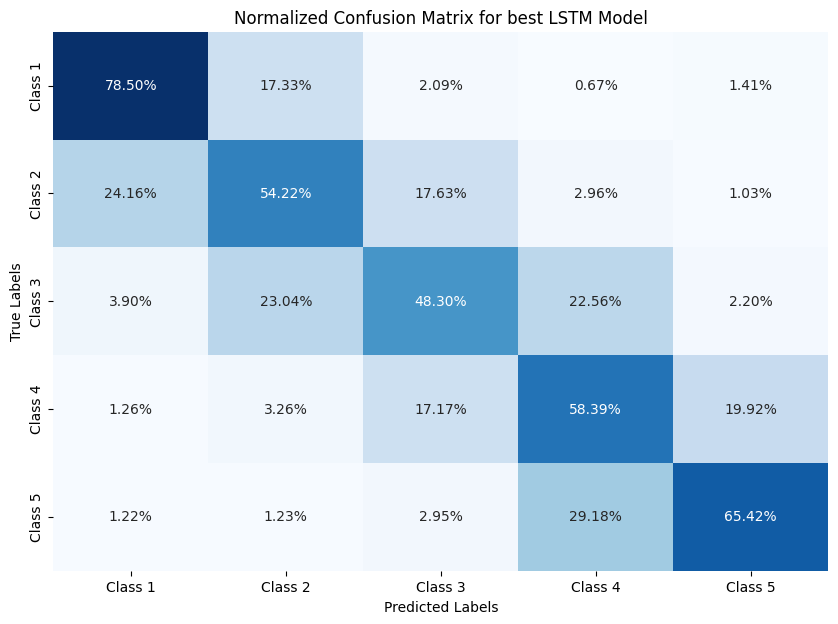

In [ ]:
# Making a normalized confusion matrix for LSTM Model

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix_percentage = conf_matrix_normalized * 100  # Convert to percentage

# Create annotations with percentage values
annot = np.array([["{:.2f}%".format(value) for value in row] for row in conf_matrix_percentage])

# Plotting the normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_percentage, annot=annot, fmt="", cmap='Blues', cbar=False,
            xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'],
            yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5'])
plt.title('Normalized Confusion Matrix for best model LSTM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

- Getting the examples that were misclassified by the best model for LSTM on test set

In [ ]:
from tensorflow.keras.models import load_model
# Load the saved LSTM model
best_model_lstm = load_model('/content/drive/My Drive/Colab Notebooks/NLP/best_model_lstm.h5')

# Predicting on test set
predictions = best_model_lstm.predict(test_sequences)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_encoded, axis=1)

# Finding mismatches between true labels and predictions
mismatches = np.where(predicted_classes != true_classes)[0]
# Create a list to store up to 10 examples of misclassification
misclassified_examples = []

# Iterate over the mismatches and store examples until we have 20
for idx in mismatches:
    if len(misclassified_examples) >= 20:
        break  # Stop collecting examples once we have 20
    true_class = true_classes[idx]
    predicted_class = predicted_classes[idx]
    misclassified_examples.append({
        'Text': " ".join(tokenized_test_texts[idx]),  # Convert list of tokens back to string for display
        'True Class': true_class,
        'Predicted Class': predicted_class
    })

# Print out the 10 misclassified examples
for example in misclassified_examples:
    print(f"True Class: {example['True Class']}, Predicted Class: {example['Predicted Class']}")
    print(f"Text: {example['Text']}\n")

True Class: 2, Predicted Class: 1
Text: tiny starbucks location like although cute make wonder really meant hang grab coffee leave leaving always good idea location anyway since nice fountain back bench central part waterfront shopping nstarbuck favorite coffee chain mean starbuck coffee taste little burnt bitter matter trendy cool upscale establishment get around yicky tasting bitterness staryucks regular coffee talk roasting bean maybe something changed regular coffee drank year one soy caramel latte foofy stuff still give establishment tres estrellas fact espresso acceptable taste half bad regular coffee bean

True Class: 1, Predicted Class: 2
Text: typical starbucks coffee chain thing dont like starbucks n ive twice time place dirty compared starbucks n use bathroom give key thats attached nasty bottle im pretty sure dont clean bottle every use even nightly naside good coffee fast friendly service

True Class: 3, Predicted Class: 4
Text: friend piano teacher took good sign sing sin

## DistilBERT Classifier

In [ ]:
# Step 1: Initialize DistilBERT Tokenizer
# This will convert texts into a format that distilBERT can understand, including splitting into tokens, converting tokens to IDs, and creating attention masks.

from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

# Function to encode the texts
def encode_texts(texts):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,  # Add special tokens ([CLS], [SEP])
        max_length= 75,  # lowering the max length of the texts from 100 to 75
        padding='max_length',  # Pad all sentences to the max_length
        truncation=True,  # Ensure longer texts are truncated to max_length
        return_attention_mask=True,  # Include attention masks
        return_tensors='pt',  # Return PyTorch tensors
    )

# Encoding text datasets
encoded_train_distilbert = encode_texts(preprocessed_train_texts['text'].tolist())
encoded_val_distilbert = encode_texts(preprocessed_val_texts['text'].tolist())
encoded_test_distilbert = encode_texts(preprocessed_test_texts['text'].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [ ]:
# Step 2: Prepare Model Inputs
# From the encoding step, extracting the input IDs and attention masks, which are needed for training BERT.

train_inputs = encoded_train_distilbert['input_ids']
train_masks = encoded_train_distilbert['attention_mask']
val_inputs = encoded_val_distilbert['input_ids']
val_masks = encoded_val_distilbert['attention_mask']
test_inputs = encoded_test_distilbert['input_ids']
test_masks = encoded_test_distilbert['attention_mask']

In [ ]:
# Step 3: Convert Labels
import torch

train_labels = torch.tensor(preprocessed_train_labels['label'].values)
val_labels = torch.tensor(preprocessed_val_labels['label'].values)
test_labels = torch.tensor(preprocessed_test_labels['label'].values)

In [ ]:
# Step 4: Create Data Loaders
# Using DataLoaders for efficient training.

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define batch size
batch_size = 64

# Create the DataLoader for training data
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for validation data
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Repeat for test data
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

- ITERATION 1

In [ ]:
# Step 5: Compile and Train Model

from transformers import DistilBertForSequenceClassification, AdamW, get_scheduler
import torch

epochs = 3

# Load DistilBERT for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_scheduler(
    "linear",                # This linear reduction helps in fine-tuning the model's weights more delicately
                             # as training progresses, potentially leading to better performance and convergence stability
                             # by reducing the chance of overshooting minima in the loss landscape.
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Arrays to store metrics for plotting
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training function
def train_model(model, train_dataloader, val_dataloader, epochs):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_dataloader:
            batch = [item.to(device) for item in batch]
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            total_train_accuracy += np.mean(preds == labels)

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0
        for batch in val_dataloader:
            batch = [item.to(device) for item in batch]
            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            total_val_accuracy += np.mean(preds == labels)

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')

    print("Training complete")
    return train_losses, train_accuracies, val_losses, val_accuracies

# Call the training function
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, val_dataloader, epochs)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Train Loss: 0.9819, Train Acc: 0.5699, Val Loss: 0.9136, Val Acc: 0.5994
Epoch 2/3 - Train Loss: 0.8360, Train Acc: 0.6347, Val Loss: 0.9035, Val Acc: 0.6085
Epoch 3/3 - Train Loss: 0.6217, Train Acc: 0.7348, Val Loss: 1.0398, Val Acc: 0.5978
Training complete


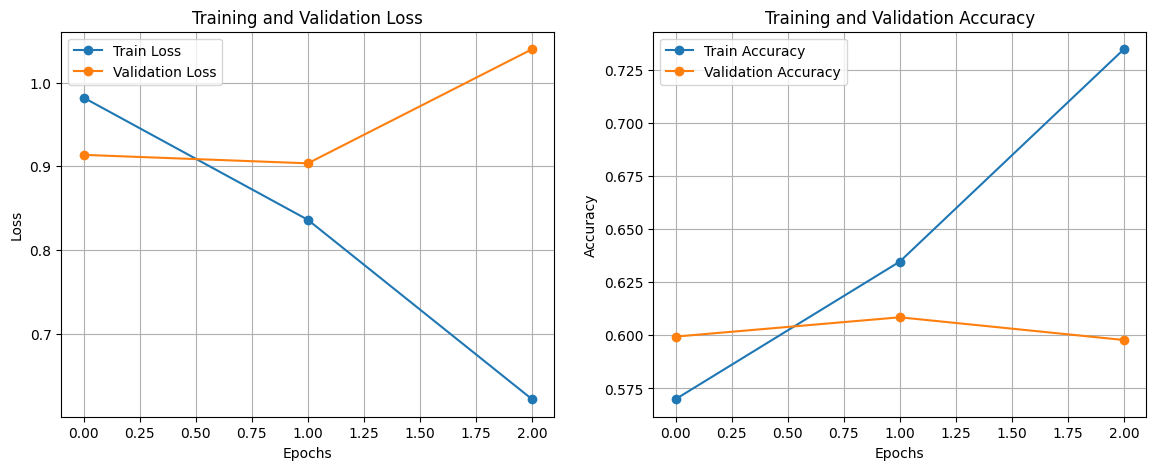

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Training Loss')
plt.plot(val_losses, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'o-', label='Training Accuracy')
plt.plot(val_accuracies, 'o-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

We started with a basic configuration of the DistilBERT model, training it for 3 epochs. This iteration focused on establishing a baseline performance to understand how the model handles the multi-class sentiment classification right out of the box. The model was trained with a learning rate of 5e-5 and utilized a linear scheduler to manage the learning rate throughout the training. This initial step provided us with essential insights into the model's capabilities and limitations. But we can see that there is an issue with overfitting here

- ITERATION 2

(extend the training to 10 epochs and adjusted the learning rate to 3e-5 to achieve finer tuning of the model parameters.)

In [ ]:
from transformers import DistilBertForSequenceClassification, AdamW, get_scheduler
import torch

epochs = 10  # Increased number of epochs

# Load DistilBERT for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=5,
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=3e-5) # Lowered the learning rate

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training function
def train_model(model, train_dataloader, val_dataloader, epochs, save_path):
    best_val_accuracy = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in train_dataloader:
            batch = [item.to(device) for item in batch]
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_train_loss += loss.item()
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            total_train_accuracy += np.mean(preds == labels)

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_accuracy)

        model.eval()
        total_val_loss = 0
        total_val_accuracy = 0

        for batch in val_dataloader:
            batch = [item.to(device) for item in batch]
            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            total_val_accuracy += np.mean(preds == labels)

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')

        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model with validation accuracy: {avg_val_accuracy:.4f} at {save_path}")

    return history

# Specify the save path in your Google Drive
save_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_distilbert_model.pth'
history = train_model(model, train_dataloader, val_dataloader, epochs, save_path)

# `history` dictionary contains train and validation loss and accuracy, ready for plotting.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Train Loss: 0.9847, Train Acc: 0.5693, Val Loss: 0.9358, Val Acc: 0.5940
Saved best model with validation accuracy: 0.5940 at /content/drive/My Drive/Colab Notebooks/NLP/best_distilbert_model.pth
Epoch 2/10 - Train Loss: 0.8707, Train Acc: 0.6191, Val Loss: 0.9113, Val Acc: 0.6062
Saved best model with validation accuracy: 0.6062 at /content/drive/My Drive/Colab Notebooks/NLP/best_distilbert_model.pth
Epoch 3/10 - Train Loss: 0.7792, Train Acc: 0.6609, Val Loss: 0.9274, Val Acc: 0.6040
Epoch 4/10 - Train Loss: 0.6786, Train Acc: 0.7081, Val Loss: 0.9901, Val Acc: 0.6005
Epoch 5/10 - Train Loss: 0.5770, Train Acc: 0.7561, Val Loss: 1.1074, Val Acc: 0.5918
Epoch 6/10 - Train Loss: 0.4787, Train Acc: 0.8027, Val Loss: 1.2444, Val Acc: 0.5870
Epoch 7/10 - Train Loss: 0.3891, Train Acc: 0.8428, Val Loss: 1.4075, Val Acc: 0.5791
Epoch 8/10 - Train Loss: 0.3139, Train Acc: 0.8760, Val Loss: 1.5640, Val Acc: 0.5814
Epoch 9/10 - Train Loss: 0.2528, Train Acc: 0.9015, Val Loss: 1.75

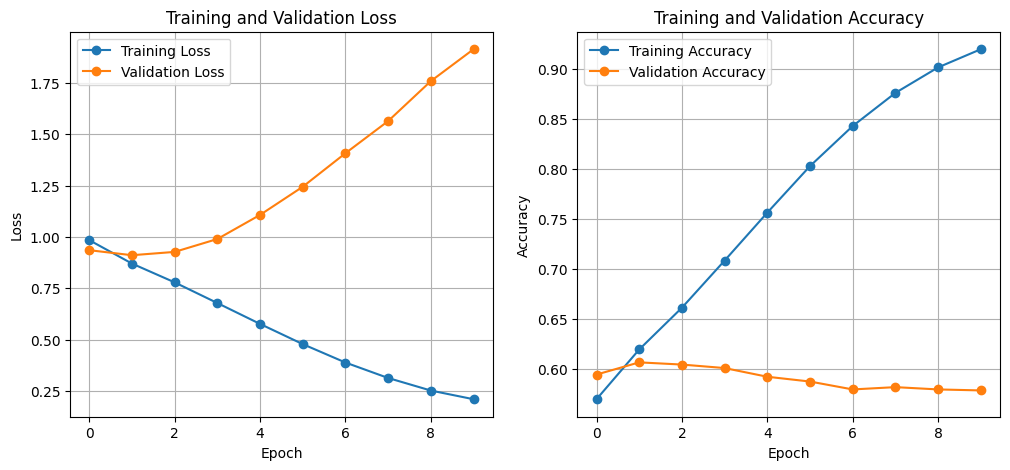

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Training Loss')
plt.plot(val_losses, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'o-', label='Training Accuracy')
plt.plot(val_accuracies, 'o-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

This step allowed the model more exposure to the training data, to potentially enhance its ability to generalize across unseen texts. Throughout this phase, we closely monitored validation loss and accuracy to ensure that the model was not just fitting to the training data but also performing well on the validation set. But this was not the case. The overfitting issue persisted and thus we had to make some changes and hence moved to iteration 3.

- ITERATION 3

Changes made from above code to increase the performance of distilBERT model:
- 1) Dropout Configuration: Enhanced the model's configuration by explicitly setting dropout rates (dropout and attention_dropout) to 0.3 to prevent overfitting as we experienced above.
- 2) Weight Decay: Added L2 regularization (weight_decay=0.01) to the optimizer to control overfitting by penalizing large weights in the model's parameters.
- 3) Scheduler with Warmup: Introduced a warmup phase in the learning rate scheduler (constant_with_warmup), which gradually increases the learning rate from zero to the set learning rate over 10% of the training duration. This helps stabilize training in its initial phases.


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertConfig
import torch
from torch.optim import AdamW  # Use AdamW from PyTorch
from transformers import get_scheduler

# Define the epochs and batch size
epochs = 5 # Increase the number of epochs to allow more learning time

# Enhanced model configuration with dropout
config = DistilBertConfig.from_pretrained(
    'distilbert-base-cased',
    num_labels=5,  # The number of output labels
    dropout=0.3,  # Dropout rate for all fully connected layers in the embeddings, encoder, and pooler
    attention_dropout=0.3,  # Dropout rate for the attention probabilities
    output_attentions=False,
    output_hidden_states=False,
)

# Load DistilBERT with the updated configuration
model = DistilBertForSequenceClassification(config)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer with a specific learning rate and weight decay for regularization
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)  #  adding weight decay

# Calculate the total number of training steps which is used to configure the scheduler
total_steps = len(train_dataloader) * epochs

# Scheduler with a linear warm-up phase. Warmup is crucial for training deep learning models
# to prevent them from diverging during the initial stages of training.
scheduler = get_scheduler(
    name="constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=total_steps // 10,  # 10% of total training steps are used for the warmup
    num_training_steps=total_steps  # Total training steps define the learning rate decay
)

# Arrays to store metrics for plotting
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

# Training function to train and validate the model
def train_model(model, train_dataloader, val_dataloader, epochs):
    best_val_accuracy = 0  # Track the best validation accuracy to save the best model

    for epoch in range(epochs):  # Loop over the dataset multiple times
        model.train()  # Set model to training mode
        total_train_loss = 0
        total_train_accuracy = 0

        # Training loop
        for batch in train_dataloader:
            batch = [item.to(device) for item in batch]  # Move batch to device (GPU or CPU)
            b_input_ids, b_input_mask, b_labels = batch

            model.zero_grad()  # Zero the parameter gradients
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()  # Backpropagate the error
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()  # Perform a single optimization step
            scheduler.step()  # Update the scheduler

            total_train_loss += loss.item()
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            total_train_accuracy += (preds == labels).mean()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        total_val_accuracy = 0
        for batch in val_dataloader:
            batch = [item.to(device) for item in batch]
            b_input_ids, b_input_mask, b_labels = batch

            with torch.no_grad():  # Disabling gradient calculation is important for validation
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            labels = b_labels.detach().cpu().numpy()
            total_val_accuracy += (preds == labels).mean()

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = total_val_accuracy / len(val_dataloader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f'Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')

        # Save the best model
        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            # Saving the model with different name as above so as to not get confused
            model_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_distilbert_model_iteration3.pth'
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with validation accuracy: {avg_val_accuracy:.4f}")

    print("Training complete")

# Call the training function
train_model(model, train_dataloader, val_dataloader, epochs)

Epoch 1/5 - Train Loss: 1.1678, Train Acc: 0.4813, Val Loss: 1.0338, Val Acc: 0.5483
Saved best model with validation accuracy: 0.5483
Epoch 2/5 - Train Loss: 1.0271, Train Acc: 0.5519, Val Loss: 1.0215, Val Acc: 0.5530
Saved best model with validation accuracy: 0.5530
Epoch 3/5 - Train Loss: 0.9982, Train Acc: 0.5653, Val Loss: 1.0014, Val Acc: 0.5658
Saved best model with validation accuracy: 0.5658
Epoch 4/5 - Train Loss: 0.9776, Train Acc: 0.5753, Val Loss: 1.0108, Val Acc: 0.5664
Saved best model with validation accuracy: 0.5664
Epoch 5/5 - Train Loss: 0.9575, Train Acc: 0.5845, Val Loss: 1.0149, Val Acc: 0.5647
Training complete


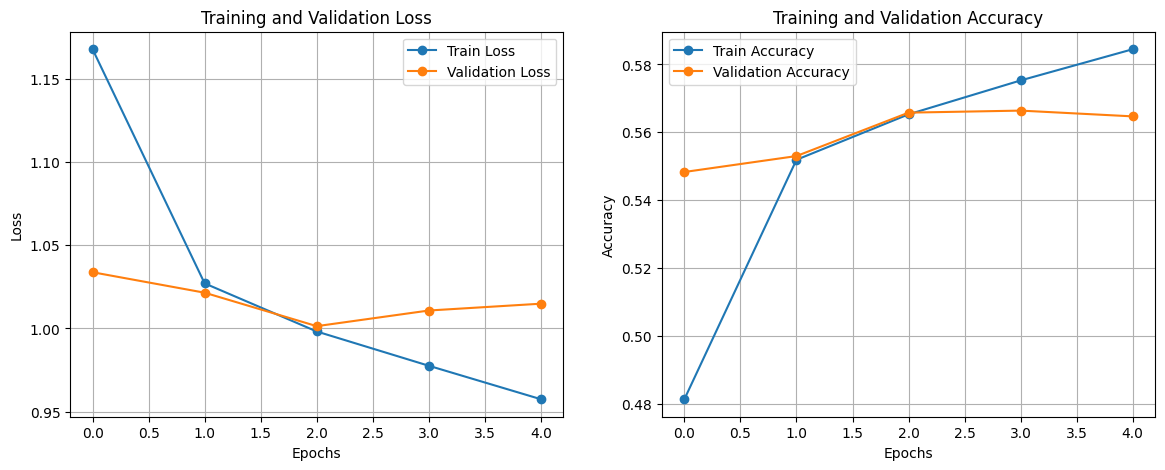

In [ ]:
# Set up the figure and axes for plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting training and validation losses
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='o')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)  # Apply grid to the first subplot

# Plotting training and validation accuracies
axes[1].plot(train_accuracies, label='Train Accuracy', marker='o')
axes[1].plot(val_accuracies, label='Validation Accuracy', marker='o')
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)  # Apply grid to the second subplot

# Show the plots
plt.show()

 To address the overfitting observed in the previous iteration, we implemented additional changes, including adjusting dropout rates and extending the warmup phase of the learning rate scheduler. However, these modifications did not yield the desired results; the validation accuracy in this third iteration did not surpass 58%, indicating that the changes might have been too aggressive or insufficiently targeted.
 Given the challenges encountered in further iterations, we opted to use the best-performing model from the second iteration. This decision was based on achieving the highest observed validation accuracy of approximately 60.8%, despite the persistence of overfitting issues.

- Testing the best model obtained from iteration 2 for DistilBERT on the Test set

              precision    recall  f1-score   support

     Class 1       0.76      0.68      0.72      9998
     Class 2       0.52      0.60      0.56     10000
     Class 3       0.52      0.52      0.52     10000
     Class 4       0.53      0.51      0.52     10000
     Class 5       0.71      0.70      0.71     10000

    accuracy                           0.60     49998
   macro avg       0.61      0.60      0.60     49998
weighted avg       0.61      0.60      0.60     49998



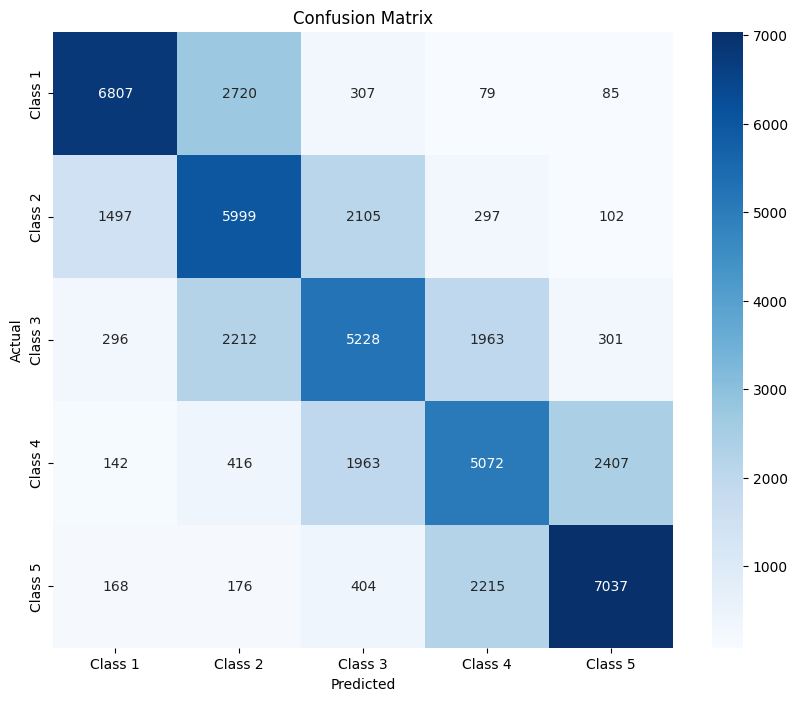

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, DistilBertConfig
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the configuration and model from saved state
config = DistilBertConfig.from_pretrained('distilbert-base-cased', num_labels=5)
model_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_distilbert_model.pth'
model = DistilBertForSequenceClassification(config)
model.load_state_dict(torch.load(model_path))
model.eval()

# Move model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to evaluate the model on the test set
def evaluate_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(b_input_ids, attention_mask=b_input_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(b_labels.detach().cpu().numpy())

    return all_labels, all_preds

all_labels, all_preds = evaluate_model(model, test_dataloader)

# Compute and print the classification report
print(classification_report(all_labels, all_preds, target_names=["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]))

# Compute and plot the confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"], yticklabels=["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

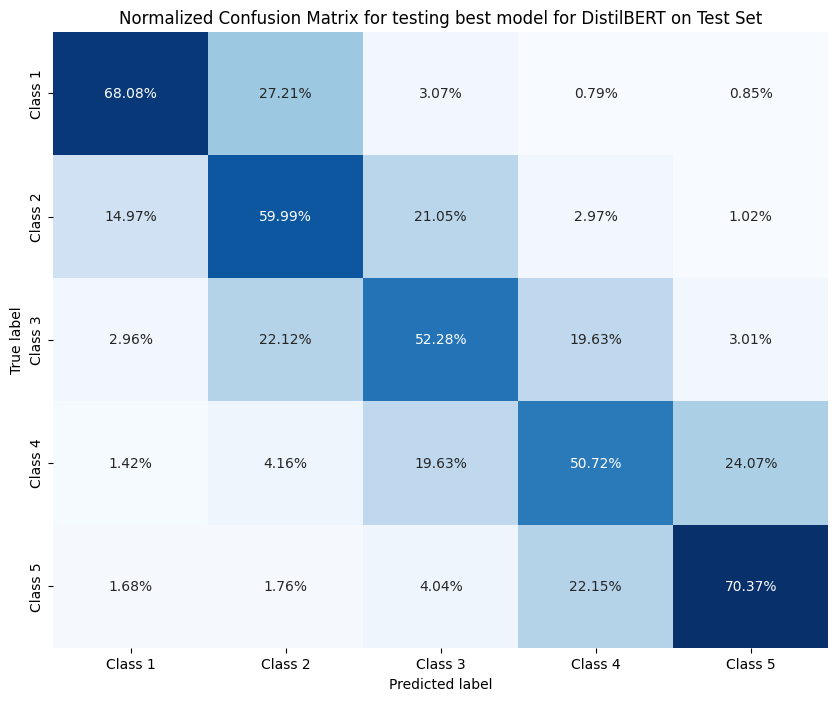

In [ ]:
# Making a normalized confusion matrix

# Function to plot a normalized confusion matrix with percentages only
def plot_normalized_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix
    cm_percentage = cm_normalized * 100  # Convert to percentage

    # Format the annotations to include only percentages
    annotations = (np.asarray(["{0:.2f}%".format(value)
                               for row in cm_percentage
                               for value in row])
                   ).reshape(cm.shape)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=annotations, fmt="", cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Normalized Confusion Matrix for testing best model for DistilBERT on Test Set')
    plt.show()

# Assuming all_labels and all_preds are available from the evaluation
classes = ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]
plot_normalized_confusion_matrix(all_labels, all_preds, classes)

- Getting examples of misclassified texts from best model of DistilBERT on test set

In [ ]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertTokenizer
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
# Load the DistilBERT model
config = DistilBertConfig.from_pretrained('distilbert-base-cased', num_labels=5)
model_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_distilbert_model.pth'
model = DistilBertForSequenceClassification(config)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

device = torch.device("cpu")
model.to(device)

# Function to evaluate the model and find misclassifications
def find_misclassified(model, dataloader, num_examples=10):
    model.eval()
    misclassified_examples = []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            outputs = model(b_input_ids, attention_mask=b_input_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            # Compare predictions to the true labels
            mismatches = preds != b_labels
            if mismatches.any():
                # Iterate over the batch to find mismatches
                for i in range(b_input_ids.size(0)):
                    if mismatches[i]:
                        misclassified_examples.append({
                            'Text': tokenizer.decode(b_input_ids[i], skip_special_tokens=True),
                            'True Class': b_labels[i].item(),
                            'Predicted Class': preds[i].item()
                        })
                        if len(misclassified_examples) >= num_examples:
                            return misclassified_examples

    return misclassified_examples

# Retrieve 10 misclassified examples
misclassified_examples = find_misclassified(model, test_dataloader, num_examples=10)

# Print the misclassified examples
for example in misclassified_examples:
    print(f"Text: {example['Text']}")
    print(f"True Class: {example['True Class']}, Predicted Class: {example['Predicted Class']}\n")

Text: food good husband ate couple week ago first time ordered salad basil pesto cream pasta husband ordered spinach feta pasta salad huge plate spring mix nothing else way much vinegar dressing lettuce drowning vinegar pesto pasta flavor taste like cream sauce pesto runny watery way much sauce enough noodle husband pasta
True Class: 0, Predicted Class: 1

Text: much fun ni wish could play song drop hat bad never took piano lesson probably end mumbling half lyric chorus unless salt pepa shoop nthis really great place go town guest looking fun place take someone birthday celebration fun night something different boozing bar saturday night nkeep mind paying around cover plus whatever drink food get good thing food coming
True Class: 3, Predicted Class: 4

Text: keep short sweet save buy good board game alcohol choice order pizza invite friend nwhat incredible disappointment seeing enticing commercial many time decided give place try double date understand price play card dispute however 

## BERT (uncased) Classifier

In [ ]:
# For reference for code for BERT model, i have taken help from : https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b

# Step 1: Setup Tokenization and DataLoader

from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts['text'].tolist()
        self.labels = labels['label'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128 # Increasing the max length of the texts to check if the accuracy increases with this
batch_size = 32 # Lowering the batch size to check if the accuracy increases with this change

# Create datasets
train_dataset = TextDataset(preprocessed_train_texts, preprocessed_train_labels, tokenizer, max_length)
val_dataset = TextDataset(preprocessed_val_texts, preprocessed_val_labels, tokenizer, max_length)
test_dataset = TextDataset(preprocessed_test_texts, preprocessed_test_labels, tokenizer, max_length)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Step 2: Define BERT-based Classifier Model

from transformers import BertModel
from torch import nn

class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

# Initialize the BERT Classifier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier('bert-base-uncased', 5).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Step 3: Define Optimizer and Training Functions

from torch.optim import AdamW
from transformers import get_scheduler

num_epochs = 5

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_loader) * num_epochs
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training function (as defined in your previous setup)
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)
        total_loss += loss.item()

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    accuracy = correct_predictions / total_predictions
    return accuracy, total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.size(0)
            total_loss += loss.item()

    accuracy = correct_predictions / total_predictions
    return accuracy, total_loss / len(data_loader)

In [ ]:
# Step 4: Initialize Training and Save Best Model

# Parameters setup
num_epochs = 5
best_val_accuracy = 0
save_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_bert_model.pth'

# Loop through each epoch for training and validation
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f"Training loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")

    val_acc, val_loss = eval_model(model, val_loader, device)
    print(f"Validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

    # Save the model if it has the best validation accuracy so far
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model with validation accuracy: {val_acc:.4f} at {save_path}")

Epoch 1/5
Training loss: 0.9121, accuracy: 0.6006
Validation loss: 0.8400, accuracy: 0.6308
Saved best model with validation accuracy: 0.6308 at /content/drive/My Drive/Colab Notebooks/NLP/best_bert_model.pth
Epoch 2/5
Training loss: 0.7848, accuracy: 0.6576
Validation loss: 0.8251, accuracy: 0.6395
Saved best model with validation accuracy: 0.6395 at /content/drive/My Drive/Colab Notebooks/NLP/best_bert_model.pth
Epoch 3/5
Training loss: 0.6769, accuracy: 0.7075
Validation loss: 0.8814, accuracy: 0.6355
Epoch 4/5
Training loss: 0.5610, accuracy: 0.7643
Validation loss: 0.9665, accuracy: 0.6321
Epoch 5/5
Training loss: 0.4613, accuracy: 0.8120
Validation loss: 1.0985, accuracy: 0.6258


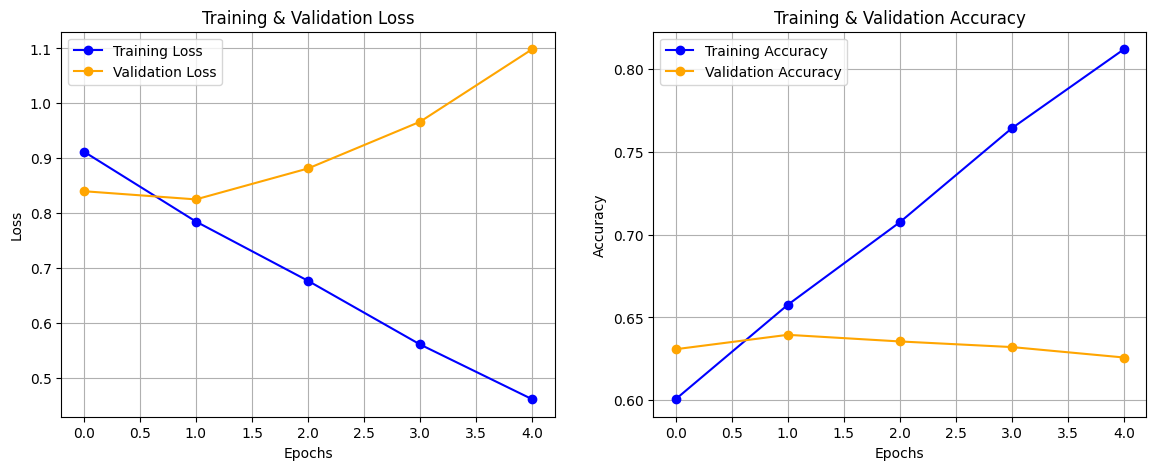

In [ ]:
import matplotlib.pyplot as plt

# Data from the training output
train_losses = [0.9121, 0.7848, 0.6769, 0.5610, 0.4613]
val_losses = [0.8400, 0.8251, 0.8814, 0.9665, 1.0985]
train_accuracies = [0.6006, 0.6576, 0.7075, 0.7643, 0.8120]
val_accuracies = [0.6308, 0.6395, 0.6355, 0.6321, 0.6258]

# Setup the figure and axis for two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot for training and validation loss
ax[0].plot(train_losses, 'o-', color='blue', label='Training Loss')
ax[0].plot(val_losses, 'o-', color='orange', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# Plot for training and validation accuracy
ax[1].plot(train_accuracies, 'o-', color='blue', label='Training Accuracy')
ax[1].plot(val_accuracies, 'o-', color='orange', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].grid(True)

# Show the plots
plt.show()

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      9998
           1       0.58      0.53      0.55     10000
           2       0.55      0.57      0.56     10000
           3       0.55      0.57      0.56     10000
           4       0.73      0.71      0.72     10000

    accuracy                           0.63     49998
   macro avg       0.63      0.63      0.63     49998
weighted avg       0.63      0.63      0.63     49998



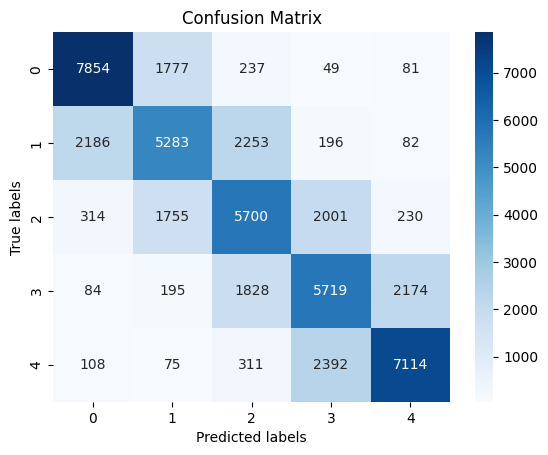

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

model = BERTClassifier('bert-base-uncased', 5)
model_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_bert_model.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model
model.load_state_dict(torch.load(model_path))
model.to(device)

# Function to evaluate the model on the test set
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    print(classification_report(true_labels, predictions))
    conf_matrix = confusion_matrix(true_labels, predictions)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
evaluate_model(model, test_loader, device)

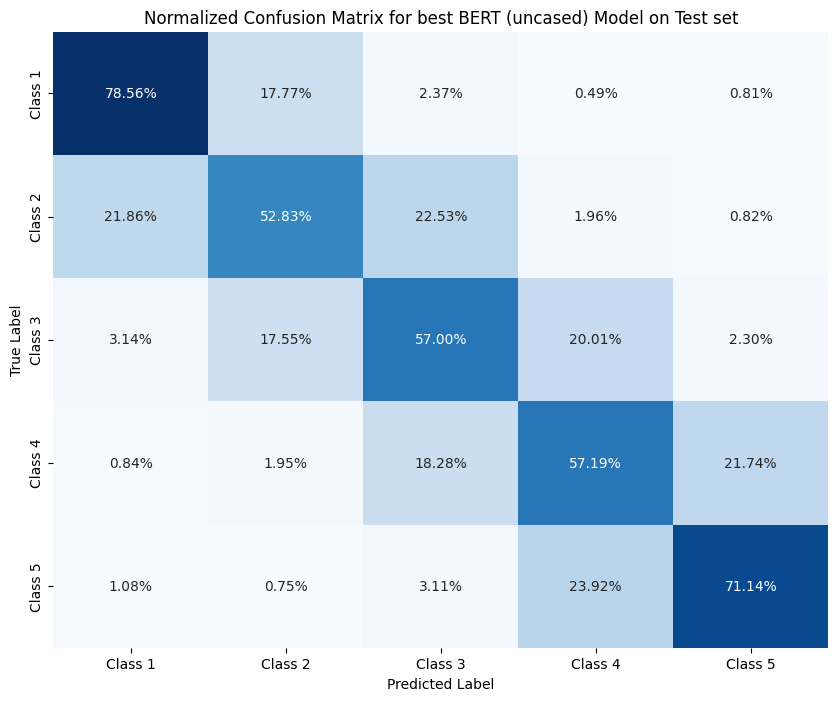

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix
    cm_percentage = cm_normalized * 100  # Convert to percentages

    # Create annotations that only show percentages
    annotations = [["{0:.2f}%".format(value) for value in row] for row in cm_percentage]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=annotations, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Normalized Confusion Matrix for best BERT (uncased) Model on Test set')
    plt.show()

# Sample usage:
class_names = ["Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]
# Assuming `all_labels` and `all_preds` are your actual labels and predictions
plot_normalized_confusion_matrix(true_labels, predictions, class_names)

- Getting the misclassified examples from the best model BERT on test set

In [ ]:
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

# Load the best model
model_path = '/content/drive/My Drive/Colab Notebooks/NLP/best_bert_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Function to evaluate the model and collect misclassified examples
def find_misclassified(model, dataloader, device, num_examples=10):
    misclassified_examples = []
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            # Check for misclassifications
            mismatches = preds != labels
            for i in range(input_ids.size(0)):
                if mismatches[i]:
                    misclassified_examples.append({
                        'Text': tokenizer.decode(input_ids[i], skip_special_tokens=True),
                        'True Class': labels[i].item(),
                        'Predicted Class': preds[i].item()
                    })
                    if len(misclassified_examples) >= num_examples:
                        return misclassified_examples
    return misclassified_examples

# Retrieve 10 misclassified examples
misclassified_examples = find_misclassified(model, test_loader, device, num_examples=10)

# Print the misclassified examples
for example in misclassified_examples:
    print(f"Text: {example['Text']}")
    print(f"True Class: {example['True Class']}, Predicted Class: {example['Predicted Class']}\n")

Text: typical starbucks coffee chain thing dont like starbucks n ive twice time place dirty compared starbucks n use bathroom give key thats attached nasty bottle im pretty sure dont clean bottle every use even nightly naside good coffee fast friendly service
True Class: 1, Predicted Class: 2

Text: friend piano teacher took good sign sing sing would quality stuff birthday really know anything dueling piano bar picturing glossy black grand piano glittering note pianist black jacket crystal glass full red wine really really glad wrong nit gritty bawdy quintessentially pittsburgh first piano scuffed hell considering number tipsy people sit nightly mildly humiliated musician hammer away covered sing sing sticker obvious well loved music anything elevator music picturing rock hip hop oldie pop genre imaginable thanks request system send piece paper money amazing repertoire musician instance rubber ducky gangsta paradise featured performed impeccably also honored request taylor swift song r